In [ ]:
# CLAIM: Analysis of potential overlapping gene pairs indicates that many are likely spurious. 

In [ ]:
import pandas as pd 
import os 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.ticker as tick 
import seaborn as sns 
import glob
from matplotlib.gridspec import GridSpec
from src.files import FASTAFile, InterProScanFile
from tqdm import tqdm
from src.reference import annotate
import src.reference as reference
from scipy.stats import chisquare, chi2_contingency, mannwhitneyu
from scipy.stats.contingency import expected_freq
import re
from src.files import BLASTJsonFile

%load_ext autoreload 
%autoreload 2

get_percent = lambda n, total : f'{100 * n / total:.2f}%' if (total > 0) else '0%'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [721]:
def get_chi_square_p_value(observed_counts_df:pd.DataFrame):
    # totals = observed_counts_df.sum(axis=1)
    # Not sure if I should be testing for independence, or using the null that they are equally-distributed. 
    # expected_counts_df = pd.DataFrame(0.5, index=observed_counts_df.index, columns=observed_counts_df.columns)
    # expected_counts_df = expected_counts_df.mul(totals, axis=0)
    expected_counts_df = pd.DataFrame(expected_freq(observed_counts_df), index=observed_counts_df.index, columns=observed_counts_df.columns) # This uses frequencies based on the marginal frequencies.
    p = chisquare(observed_counts_df.values.ravel(), expected_counts_df.values.ravel()).pvalue
    return p

In [756]:
dataset_df = pd.read_csv('../data/results/results-2/dataset.csv', index_col=0)
# Some of these are null instead of NaN because of the capitalized Nones.
# dataset_df['query_rbs_motif'] = np.where(dataset_df.query_rbs_motif.isnull(), 'none', dataset_df.query_rbs_motif)
all_hits_df = pd.read_csv('../data/results/results-2/all_hits.csv', index_col=0)

dataset_df = annotate(dataset_df)
dataset_df['top_hit_hypothetical'] = dataset_df.top_hit_product == 'hypothetical protein'
# Make sure these are in units of amino acids. 
dataset_df['query_length'] = dataset_df.seq.apply(len)
dataset_df['top_hit_length'] = dataset_df.top_hit_seq.apply(len)
all_hits_df = annotate(all_hits_df, prefix='subject')

# Exclude genomes on which Prodigal did horrifically (I think I needed to use a different translation table). 
# Also, one of the excluded genomes belongs to an endosymbiont which is not assigned a phylum.
exclude_genome_ids = ['GCF_029854295.1', 'GCF_021057185.1', 'GCF_016097415.1'] 
dataset_df = dataset_df[~dataset_df.genome_id.isin(exclude_genome_ids)].copy()

interpro_df = pd.concat([InterProScanFile(path).to_df() for path in glob.glob('../data/interpro/*')])
ids_with_antifam_hit = interpro_df[interpro_df.interpro_analysis == 'AntiFam'].index.unique()
ids_with_antifam_hit = np.intersect1d(ids_with_antifam_hit, dataset_df.index) # Make sure to remove AntiFam hits from the excluded genomes.
dataset_df['antifam_hit'] = dataset_df.index.isin(ids_with_antifam_hit)

antifam_interpro_df = interpro_df.loc[ids_with_antifam_hit].sort_values('interpro_e_value')
antifam_interpro_df = antifam_interpro_df[~antifam_interpro_df.index.duplicated(keep='first')].copy()

print('Num. proteins with AntiFam hit:', len(ids_with_antifam_hit))
for description, df in antifam_interpro_df.groupby('interpro_signature_description'):
    description = description[0].lower() + description[1:]
    print(f'\tNum. {description}:', len(df))


Num. proteins with AntiFam hit: 27
	Num. antisense to 23S rRNA: 5
	Num. antisense to RNaseP: 2
	Num. translation of CRISPR region: 9
	Num. tRNA translation: 11


In [757]:
is_cds_conflict = lambda df : (df.conflict) & (df.top_hit_feature == 'CDS') & (~df.top_hit_pseudo)
is_antiparallel_cds_conflict = lambda df : is_cds_conflict(df) & (df.overlap_type.isin(['convergent', 'divergent']))
is_hypothetical_cds_conflict = lambda df : df.conflict & (df.top_hit_product == 'hypothetical protein')
is_supported_cds_conflict = lambda df : is_cds_conflict(df) & (~df.top_hit_hypothetical)
is_unsupported_cds_conflict = lambda df : is_cds_conflict(df) & (df.top_hit_hypothetical)
is_non_coding_conflict = lambda df : df.conflict & (df.top_hit_feature != 'CDS')

def is_top_hit_match(row, exact:bool=False):
    mask = (dataset_df.top_hit_contig_id == row.top_hit_contig_id)
    mask = mask & dataset_df.exact_match if exact else dataset_df.match
    mask = mask & (dataset_df.top_hit_locus_tag == row.top_hit_locus_tag)
    # assert mask.sum() <= 1, f'top_hit_has_match: Expected there to be at most one match, but found {mask.sum()}.'
    return mask.sum() > 0

def is_top_hit_match_in_conflict(row):
    if not row.conflict:
        return False
    mask = (dataset_df.top_hit_contig_id == row.top_hit_contig_id) & dataset_df.match
    mask = mask & (dataset_df.top_hit_locus_tag == row.top_hit_locus_tag)
    if mask.sum() < 1: # Then there is no match. 
        return False 
    assert mask.sum() == 1, f'top_hit_has_match: Expected there to be at most one match, but found {mask.sum()}.'
    top_hit_match = dataset_df[mask].iloc[0]
    return not ((row.query_stop < top_hit_match.query_start) or (row.query_start > top_hit_match.query_stop))
    
# dataset_df['top_hit_match'] = dataset_df.apply(is_top_hit_match, axis=1)
# dataset_df['top_hit_exact_match'] = dataset_df.apply(lambda row : is_top_hit_match(row, exact=True), axis=1)
dataset_df['top_hit_match_in_conflict'] = dataset_df.apply(is_top_hit_match_in_conflict, axis=1)

In [823]:
threshold = 0.8

results_df = pd.read_csv('../data/results/results-2/dataset_predict.csv', index_col=0)
results_df.columns = [col.replace('_v2', '') for col in results_df.columns]
results_df = results_df.merge(dataset_df, left_index=True, right_index=True, how='inner')
results_df['spurious'] = np.where(results_df.model_output_0 > threshold, True, False)
results_df['real'] = np.where(results_df.model_output_1 > threshold, True, False)
results_df['uncertain'] = ~results_df.real & ~results_df.spurious
results_df['model_label'] = np.select([results_df.real, results_df.spurious.values, results_df.uncertain.values], ['real', 'spurious', 'uncertain'], default='none')

top_hit_results_df = pd.read_csv('../data/results/results-2/top_hits_predict.csv', index_col=0)
top_hit_results_df.columns = [col.replace('_v2', '') for col in top_hit_results_df.columns]
top_hit_results_df = top_hit_results_df[~top_hit_results_df.index.duplicated(keep='first')].copy()

with pd.option_context('future.no_silent_downcasting', True):
    results_df['top_hit_real'] = results_df.top_hit_protein_id.map(top_hit_results_df.model_output_1 > threshold).fillna(False).astype(bool)
    results_df['top_hit_spurious'] = results_df.top_hit_protein_id.map(top_hit_results_df.model_output_0 > threshold).fillna(False).astype(bool)
    results_df['top_hit_uncertain'] = results_df.top_hit_protein_id.map((top_hit_results_df.model_output_0 <= threshold) & (top_hit_results_df.model_output_1 <= threshold)).fillna(False).astype(bool)
    results_df['top_hit_model_label'] = np.where(results_df.top_hit_real, 'real', 'none')
    results_df['top_hit_model_label'] = np.where(results_df.top_hit_spurious, 'spurious', results_df.top_hit_model_label)
    results_df['top_hit_model_label'] = np.where(results_df.top_hit_uncertain, 'uncertain', results_df.top_hit_model_label)

In [ ]:
# What fraction of conflicts are detected by Prodigal?

# Prodigal allows 60 bp of tandem overlap and 200 bp of antisense overlap (convergent only). If two genes overlap by 1 or 4 bp
# on the same strand, requirements for RBS are lifted. It is not clear to me based on the paper how overlaps are penalized. 
# Seems as though overlapping connections are scored according to the score of the second gene, though it is unclear if 
# this means the downstream gene, but I imagine it would be the lower-scoring gene?

def si_table(dataset_df:pd.DataFrame):
    dataset_df = dataset_df[is_cds_conflict(dataset_df)].copy()
    columns = ['percent_top_hit_match', 'percent_top_hit_exact_match', 'percent_top_hit_match_in_conflict']
    table_df = pd.DataFrame(index=dataset_df.overlap_type.unique())
    table_df['total'] = dataset_df.groupby('overlap_type').apply(len, include_groups=False)
    table_df['n_top_hit_match'] = dataset_df.groupby('overlap_type').top_hit_match.sum()
    table_df['n_top_hit_exact_match'] = dataset_df.groupby('overlap_type').top_hit_exact_match.sum()
    table_df['n_top_hit_match_in_conflict'] = dataset_df.groupby('overlap_type').top_hit_match_in_conflict.sum()
    for col in columns:
        table_df[col] = [get_percent(n, total) for n, total in zip(table_df[col.replace('percent', 'n')], table_df['total'])]
    return table_df[columns + ['total']]

si_table(dataset_df)

In [332]:
def si_table(dataset_df:pd.DataFrame, exclude_spurious:bool=True, normalize:bool=True):

    if exclude_spurious:
        dataset_df = dataset_df[dataset_df.real].copy()

    dataset_df = dataset_df[is_cds_conflict(dataset_df) & (dataset_df.overlap_type != 'nested')].copy()
    total = len(dataset_df)

    table_df = pd.DataFrame(index=pd.Series(['tandem', 'antiparallel'], name='direction'), columns=pd.Series([0, 1, 2], name='phase'))
    for same_strand, df in dataset_df.groupby('same_strand'):
        if same_strand:
            table_df.loc['tandem', :] = df.phase.value_counts()
        else:
            table_df.loc['antiparallel', :] = df.phase.value_counts()
    table_df = table_df.infer_objects(copy=False).fillna(0)
    if normalize:
        table_df = table_df / total

    return table_df

# Frequencies from https://pmc.ncbi.nlm.nih.gov/articles/PMC525685/. Study used 64,989 overlaps to generate this table. 
ref_table_df = pd.DataFrame([[0.001, 0.259, 0.578], [0.041, 0.062, 0.060]], index=pd.Series(['tandem', 'antiparallel'], name='direction'), columns=pd.Series([0, 1, 2], name='phase'))

# The incidence of tandem overlaps in the +1 frame is significantly higher than observed in nature. 
si_table_df = si_table(results_df, normalize=False, exclude_spurious=False)
observed_counts = si_table_df.loc['tandem', :]
expected_counts = ref_table_df.loc['tandem', :] / ref_table_df.loc['tandem', :].sum() * observed_counts.sum()
print(f'p={chisquare(observed_counts, expected_counts).pvalue}')

# The distribution of phase frequencies of the real-predicted proteins matches that observed in confirmed overlaps.
si_table_df = si_table(results_df, normalize=False, exclude_spurious=True)
observed_counts = si_table_df.values.ravel()
expected_counts = (ref_table_df.values.ravel() * observed_counts.sum())
print(f'p={chisquare(observed_counts, expected_counts, sum_check=False).pvalue}')


p=0.0002278593314510031
p=0.39205710907300867


In [333]:
total_conflict = dataset_df.conflict.sum()
n_unsupported_conflict = (dataset_df.conflict & dataset_df.top_hit_unsupported).sum()
n_hypothetical_conflict = (dataset_df.conflict & dataset_df.top_hit_hypothetical).sum()
print('Num. unsupported conflicts:', n_unsupported_conflict, f'({get_percent(n_unsupported_conflict, total_conflict)})')
print('Num. conflicts with hypothetical proteins:', n_hypothetical_conflict, f'({get_percent(n_hypothetical_conflict, total_conflict)})')

Num. unsupported conflicts: 134 (22.41%)
Num. conflicts with hypothetical proteins: 153 (25.59%)


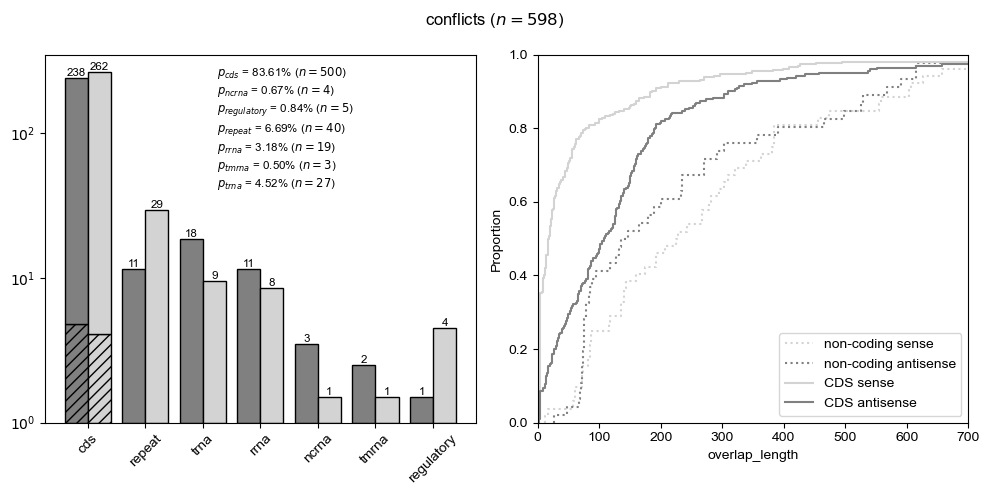

In [ ]:
def si_figure(dataset_df:pd.DataFrame):

    figure_df = dataset_df[dataset_df.conflict].copy()
    
    masks = dict()
    masks['cds'] = figure_df.top_hit_feature == 'CDS'
    masks['trna'] = figure_df.top_hit_feature == 'tRNA'
    masks['rrna'] = figure_df.top_hit_feature == 'rRNA'
    masks['tmrna'] = figure_df.top_hit_feature == 'tmRNA'
    masks['ncrna'] = figure_df.top_hit_feature == 'ncRNA'
    masks['repeat'] = figure_df.top_hit_feature == 'repeat_region'
    masks['regulatory'] = figure_df.top_hit_feature == 'regulatory'

    categories = ['cds', 'repeat', 'trna', 'rrna', 'ncrna',  'tmrna', 'regulatory']
    conditions = [masks[category] for category in categories]
    figure_df['category'] = np.select(conditions, categories, default='none')

    fig, (ax_a, ax_b) = plt.subplots(figsize=(10, 5), ncols=2) #, width_ratios=[0.6, 0.4])
    
    width = 0.4
    offsets = {True:width/2, False:-width/2}
    palette = {True:'lightgray', False:'gray'}
        
    positions = np.arange(figure_df.category.nunique())

    for same_strand, df in figure_df.groupby('same_strand'):
        ax_a_df = pd.DataFrame(index=categories)
        ax_a_df['total'] = df.category.value_counts()
        ax_a_df['log_total'] = np.log10(ax_a_df['total'] + 0.5)
        ax_a_df['fraction'] = df.groupby('category').apply(lambda df : df.top_hit_hypothetical.sum() / len(df), include_groups=False)
        ax_a_df['unsupported'] = ax_a_df['log_total'] * ax_a_df['fraction']
        ax_a_df['supported'] = ax_a_df['log_total'] * (1 - ax_a_df['fraction'])

        ax_a.bar(positions + offsets[same_strand], ax_a_df.unsupported, color=palette[same_strand], edgecolor='black', hatch='///', width=width)
        ax_a.bar(positions + offsets[same_strand], ax_a_df.supported, bottom=ax_a_df.unsupported, color=palette[same_strand], edgecolor='black', width=width)
        
        for x, total, log_total in zip(positions + offsets[same_strand], ax_a_df.total, ax_a_df.log_total):
            # text = f'{100 * total / ax_a_df.total.sum():.2f}%'
            text = str(total)
            ax_a.text(x, log_total, text, ha='center', fontsize='small', va='bottom')

    ax_a.set_xticks(positions, labels=ax_a_df.index, rotation=45)
    ax_a.set_yticks(np.arange(3), labels=[f'$10^{i}$' for i in range(3)])

    text = ''
    for category, df in figure_df.groupby('category'):
        text += '$p_{' + category + '}$' + f' = {get_percent(len(df), len(figure_df))} ($n={len(df)}$)\n'
    ax_a.text(0.4, 0.6, text, transform=ax_a.transAxes, fontsize='small')

    sns.ecdfplot(figure_df[is_non_coding_conflict(figure_df) & figure_df.same_strand], x='overlap_length', color=palette[True], ax=ax_b, ls=':', label='non-coding sense')
    sns.ecdfplot(figure_df[is_non_coding_conflict(figure_df) & ~figure_df.same_strand], x='overlap_length', color=palette[False], ax=ax_b, ls=':', label='non-coding antisense')
    sns.ecdfplot(figure_df[is_cds_conflict(figure_df) & figure_df.same_strand], x='overlap_length', color=palette[True], ax=ax_b, label='CDS sense')
    sns.ecdfplot(figure_df[is_cds_conflict(figure_df) & ~figure_df.same_strand], x='overlap_length', color=palette[False], ax=ax_b, label='CDS antisense')
    ax_b.legend()
    ax_b.set_xlim(xmin=0, xmax=700)

    fig.suptitle(f'conflicts ($n={len(figure_df)}$)')
    fig.tight_layout()
    plt.show()

si_figure(dataset_df)

In [ ]:
print('Num. conflicts with non-coding elements:', is_non_coding_conflict(dataset_df).sum())
print('Num. nested conflicts with non-coding elements:', (is_non_coding_conflict(dataset_df) & (dataset_df.overlap_type == 'nested')).sum())
print('Num. conflicts with non-coding elements where the query is completely contained within the non-coding gene:', (is_non_coding_conflict(dataset_df) & (dataset_df.query_overlap_fraction == 1)).sum())
print('Num. conflicts with non-coding elements where the non-coding gene is completely contained within the query:', (is_non_coding_conflict(dataset_df) & (dataset_df.top_hit_overlap_fraction == 1)).sum())

Num. conflicts with non-coding elements: 98
Num. nested conflicts with non-coding elements: 82
Num. conflicts with non-coding elements where the query is completely contained within the non-coding gene: 55
Num. conflicts with non-coding elements where the non-coding gene is completely contained within the query: 27


In [711]:
# print('Num. sequences which conflict with > 1 reference element:', ((dataset_df.conflict) & (dataset_df.n_hits > 1)).sum())
# print('Num. sequences which conflict with > 2 reference elements:', ((dataset_df.conflict) & (dataset_df.n_hits > 2)).sum(), end='\n\n')

# conflict_ids = dataset_df[(dataset_df.conflict) & (dataset_df.top_hit_feature == 'CDS') & (dataset_df.n_hits > 1)].index

# # Seems as though all but two sequences only conflict with other CDS. I think these can mostly be ignored, but probably an increased likelihood
# # that these sequences are spurious. 
# for id_, df in all_hits_df[all_hits_df.query_id.isin(conflict_ids)].groupby('query_id'):
#     if not np.all(df.subject_feature == 'CDS'):
#         print(f'Expected all conflicts to be with CDS, but {id_} conflicts with: ' + ', '.join(df.subject_feature))
#     if not np.all(df.conflict): # Making sure no matches snuck in. 
#         print(f'Expected all conflicting sequences to only conflict with the reference, but {id_} has hits annotated as: ' + ', '.join(df.category))
results_df.top_hit_hypothetical

id
NZ_NIGF01000005.1_149     False
NZ_CP130454.1_2326        False
NZ_AP025523.1_2138        False
NZ_OX336137.1_427         False
NC_014960.1_2574          False
                          ...  
NZ_JAALLS010000042.1_1    False
NZ_QXIU01000113.1_5       False
NZ_JAIKTU010000022.1_1    False
NZ_JAALLS010000016.1_1    False
NZ_QXIU01000167.1_6       False
Name: top_hit_hypothetical, Length: 51210, dtype: bool

In [712]:
total = is_cds_conflict(results_df).sum()
print('Num. sense CDS conflicts:', (is_cds_conflict(results_df) & (results_df.same_strand)).sum(), f'({get_percent((is_cds_conflict(results_df) & (results_df.same_strand)).sum(), total)})')
print('Num. CDS conflicts > 30 bp:', (is_cds_conflict(results_df) & (results_df.overlap_length > 30)).sum(), f'({get_percent((is_cds_conflict(results_df) & (results_df.overlap_length > 30)).sum(), total)})')
print('Num. annotated reference in conflict:', (is_cds_conflict(results_df) & (~results_df.top_hit_hypothetical)).sum(), f'({get_percent((is_cds_conflict(results_df) & (~results_df.top_hit_hypothetical)).sum(), total)})')

Num. sense CDS conflicts: 262 (54.24%)
Num. CDS conflicts > 30 bp: 272 (56.31%)
Num. annotated reference in conflict: 332 (68.74%)


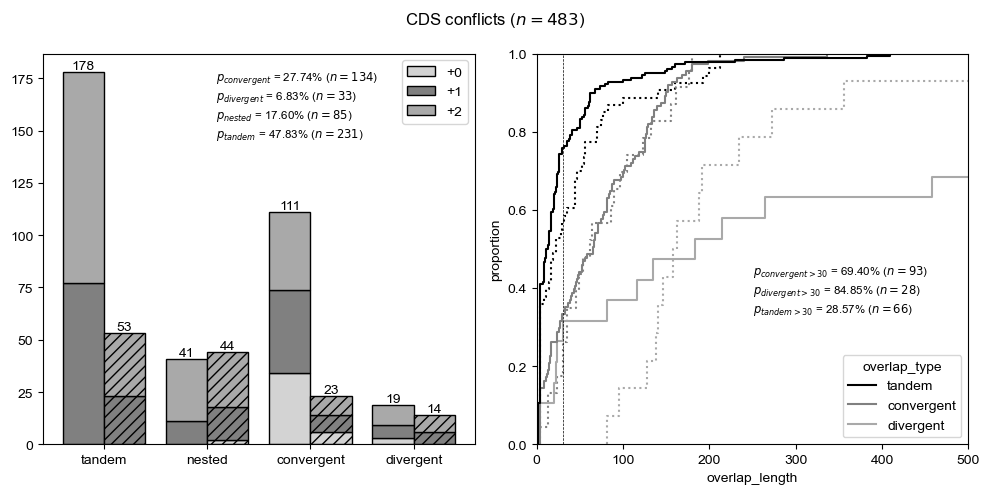

In [ ]:
# TODO: Check the overlap lengths for different frames. 

def si_figure_2(dataset_df:pd.DataFrame, exclude_nested:bool=False):
    figure_df = dataset_df[is_cds_conflict(dataset_df)].copy()
    figure_df = figure_df[figure_df.overlap_type].copy() if exclude_nested else figure_df
    
    fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))

    figure_df['phase'] = ['+' + str(int(row.phase)) for row in figure_df.itertuples()]

    palette = {'+0':'lightgray', '+1':'gray', '+2':'darkgray', 'none':'white'}
    overlap_types = figure_df.overlap_type.unique()
    positions = np.arange(len(overlap_types))
    width = 0.4

    def panel_a(ax_df:pd.DataFrame, offset:float=None, hatch=None, add_label:bool=True):
        totals =  np.zeros(len(overlap_types))
        bottom = np.zeros(len(overlap_types))
        for phase, df in ax_df.groupby('phase'):
            heights = [(df.overlap_type == overlap_type).sum() for overlap_type in overlap_types]
            ax_a.bar(positions + offset, heights, bottom=bottom, edgecolor='black', label=phase if add_label else None, color=palette[phase], width=width, hatch=hatch)
            bottom += np.array(heights)
            totals += heights
        for x, y in zip(positions + offset, totals):
            ax_a.text(x, y, str(int(y)), ha='center', va='bottom')

    panel_a(figure_df[~figure_df.top_hit_hypothetical], offset=-width/2)
    panel_a(figure_df[figure_df.top_hit_hypothetical], offset=width/2, hatch='///', add_label=False)

    text = ''
    for overlap_type, df in figure_df.groupby('overlap_type'):
        text += '$p_{' + overlap_type + '}$' + f' = {get_percent(len(df), len(figure_df))} ($n={len(df)}$)\n'
    ax_a.text(0.4, 0.75, text, transform=ax_a.transAxes, fontsize='small')

    ax_a.set_xticks(positions, labels=overlap_types)
    ax_a.legend()

    ax_b_df = figure_df[figure_df.overlap_type != 'nested'].copy()

    palette = {'tandem':'black', 'convergent':'gray', 'divergent':'darkgray'}
    sns.ecdfplot(data=ax_b_df[ax_b_df.top_hit_hypothetical], x='overlap_length', hue='overlap_type', ls=':', palette=palette, ax=ax_b)
    sns.ecdfplot(data=ax_b_df[~ax_b_df.top_hit_hypothetical], x='overlap_length', hue='overlap_type', palette=palette, ax=ax_b)
    ax_b.set_xlim(xmin=0, xmax=500)
    ax_b.set_ylabel('proportion')

    overlap_length, text = 30, ''
    for overlap_type, df in ax_b_df.groupby('overlap_type'):
        n = (df.overlap_length > overlap_length).sum()
        text += '$p_{' + overlap_type + '>' + str(overlap_length) + '}$' + f' = {get_percent(n, len(df))} ($n={n}$)\n'
    ax_b.text(0.5, 0.3, text, transform=ax_b.transAxes, fontsize='small')
    ax_b.axvline(x=overlap_length, ls='--', color='black', lw=0.5)

    fig.suptitle(f'CDS conflicts ($n={len(figure_df)}$)')
    fig.tight_layout()
    plt.show()

# si_figure_2(dataset_df, exclude_nested=True)
si_figure_2(dataset_df, exclude_nested=False)

Num. +1 tandem overlaps: 21 (9.09%)
Num. +4 tandem overlaps: 71 (30.74%)
Num. tandem overlaps > 7 bp in phase 1: 100
Num. tandem overlaps > 7 bp in phase 2: 38
Num. antiparallel overlaps > 7 bp in phase 0: 43
Num. antiparallel overlaps > 7 bp in phase 1: 41
Num. antiparallel overlaps > 7 bp in phase 2: 64


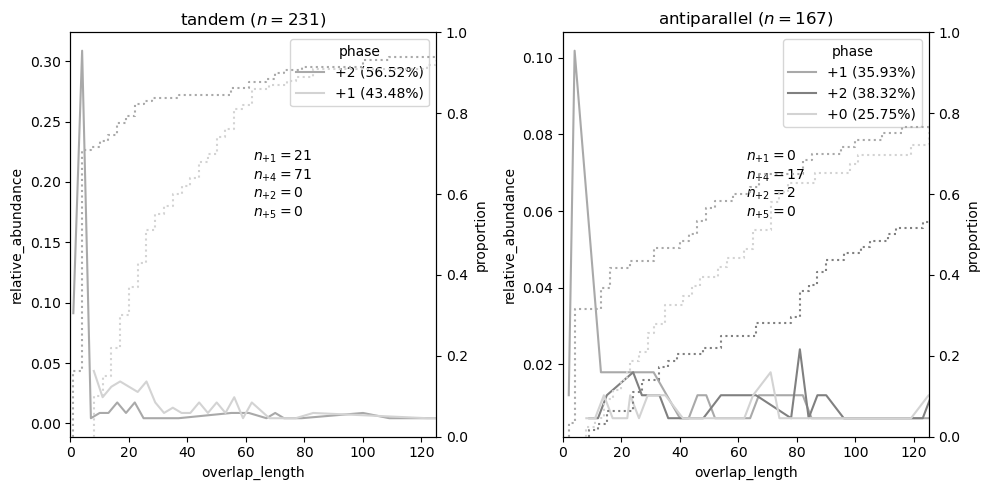

In [167]:
def si_figure(dataset_df:pd.DataFrame, supported:bool=None):
     
    if supported is not None:
        figure_df = dataset_df[is_supported_cds_conflict(dataset_df)].copy() if supported else dataset_df[is_unsupported_cds_conflict(dataset_df)].copy()
    else:
        figure_df = dataset_df[is_cds_conflict(dataset_df)].copy()

    figure_df = figure_df[figure_df.overlap_type != 'nested'].copy()
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)

    titles = {True:f'tandem ($n={figure_df.same_strand.sum()}$)', False:f'antiparallel ($n={(~figure_df.same_strand).sum()}$)'}

    for ax, same_strand in zip(axes, [True, False]):
        ax_df = figure_df[figure_df.same_strand == same_strand].copy()
        ax_df = ax_df[ax_df.index != 'NZ_FAOO01000018.1_5'] # One of the tandem overlaps is +0 because the top hit is partial, and the query has a ton of X's in the middle.
        phase_counts = ax_df.phase.value_counts().to_dict()
        ax_df['phase'] = [f'+{int(phase)} ({get_percent(phase_counts[phase], len(ax_df))})' for phase in ax_df.phase]

        palette = {label:['lightgray', 'darkgray', 'gray'][i] for i, label in enumerate(sorted(ax_df.phase.unique()))}
        ax_ = sns.ecdfplot(ax_df, x='overlap_length', hue='phase', palette=palette, ls=':', ax=ax.twinx(), legend=False)
        ax_.set_ylabel('proportion')

        phase_map = {overlap_length:phase for overlap_length, phase in zip(ax_df.overlap_length, ax_df.phase)}
        ax_df = ax_df.overlap_length.value_counts().reset_index()
        ax_df['phase'] = ax_df.overlap_length.map(phase_map)
        ax_df['relative_abundance'] = ax_df['count'] / ax_df['count'].sum()

        sns.lineplot(ax_df, x='overlap_length', y='relative_abundance', hue='phase', palette=palette, ax=ax)

        text = ''
        for overlap_length in [1, 4, 2, 5]:
            n = ax_df[ax_df.overlap_length == overlap_length]['count']
            n = 0 if len(n) == 0 else n.iloc[0]
            text += '$n_{+' + str(overlap_length) + '} = ' + str(n) + '$\n'
        ax.text(0.5, 0.5, text, transform=ax.transAxes)
        ax.set_title(titles[same_strand])

        ax.set_xlim(xmin=0, xmax=125)

    fig.tight_layout()

si_figure(dataset_df, supported=None)

n_overlap_length_1 = (is_cds_conflict(dataset_df) & (dataset_df.overlap_type == 'tandem') & (dataset_df.overlap_length == 1)).sum()
n_overlap_length_4 = (is_cds_conflict(dataset_df) & (dataset_df.overlap_type == 'tandem') & (dataset_df.overlap_length == 4)).sum()
total = (is_cds_conflict(dataset_df) & (dataset_df.overlap_type == 'tandem')).sum()

print('Num. +1 tandem overlaps:', n_overlap_length_1, f'({get_percent(n_overlap_length_1, total)})')
print('Num. +4 tandem overlaps:', n_overlap_length_4, f'({get_percent(n_overlap_length_4, total)})')

print('Num. tandem overlaps > 7 bp in phase 1:', (is_cds_conflict(dataset_df) & (dataset_df.overlap_type == 'tandem') & (dataset_df.phase == 1) & (dataset_df.overlap_length > 7)).sum())
print('Num. tandem overlaps > 7 bp in phase 2:', (is_cds_conflict(dataset_df) & (dataset_df.overlap_type == 'tandem') & (dataset_df.phase == 2) & (dataset_df.overlap_length > 7)).sum())

print('Num. antiparallel overlaps > 7 bp in phase 0:', (is_cds_conflict(dataset_df) & (dataset_df.overlap_type.isin(['convergent', 'divergent'])) & (dataset_df.phase == 0) & (dataset_df.overlap_length > 7)).sum())
print('Num. antiparallel overlaps > 7 bp in phase 1:', (is_cds_conflict(dataset_df) & (dataset_df.overlap_type.isin(['convergent', 'divergent'])) & (dataset_df.phase == 1) & (dataset_df.overlap_length > 7)).sum())
print('Num. antiparallel overlaps > 7 bp in phase 2:', (is_cds_conflict(dataset_df) & (dataset_df.overlap_type.isin(['convergent', 'divergent'])) & (dataset_df.phase == 2) & (dataset_df.overlap_length > 7)).sum())

In [ ]:
# Overlaps greater than 60 bp are almost certainly spurious. However, the proteins could still be in-frame with a genuine ORF, and the 
# overlap may be the result of a boundary error. Sequences can be extended at the N-terminus due to erroneous start-codon selection, or extended 
# at the C-terminus due to a frameshift mutation. N-terminal extensions are the most common cause of overlap, and also the simplest to detect, 
# so will probably limit analysis to these. 

# Conflicts that are potentially the result of N-terminal extension include:
# (1) Divergent overlaps where one or both sequence coordinates are the product of ab initio prediction. 
# (2) Tandem overlaps where the downstream sequence coordinates are the product of ab initio prediction. 
# (2) Nested overlaps where one or both sequence coordinates are the product of ab initio prediction. 

In [ ]:
# is_partial_at_c_terminus = lambda strand, partial : ((partial[0] == '1')) and (strand == -1) or ((partial[-1] == '1') and (strand == 1))
# is_partial_at_n_terminus = lambda strand, partial : ((partial[0] == '1')) and (strand == 1) or ((partial[-1] == '1') and (strand == -1))

# is_query_partial_at_c_terminus = lambda row : is_partial_at_c_terminus(row.query_strand, row.query_partial)
# is_top_hit_cds = lambda row : (row.top_hit_feature == 'CDS') and not row.top_hit_pseudo

# query_start_in_top_hit = lambda df : (df.query_start <= df.top_hit_stop) & (df.query_start >= df.top_hit_start)
# query_stop_in_top_hit = lambda df : (df.query_stop <= df.top_hit_stop) & (df.query_stop >= df.top_hit_start)
# is_conflict_at_query_n_terminus = lambda df : (df.query_strand == 1) & query_start_in_top_hit(df) | ((df.query_strand == -1) & query_stop_in_top_hit(df))

# has_overlap = lambda row : not ((row.query_stop < row.top_hit_start) or (row.query_start > row.top_hit_stop))
# get_overlap_length = lambda row : 0 if not has_overlap(row) else min(row.query_stop, row.top_hit_stop) - max(row.query_start, row.top_hit_start)
# get_overlap_type = lambda row : reference.get_overlap_type(query_start=row.query_start, query_stop=row.query_stop, subject_start=row.top_hit_start, subject_stop=row.top_hit_stop, query_strand=row.query_strand, subject_strand=row.top_hit_strand)

# is_conflict_from_n_terminal_extension = lambda df : df.conflict & (is_conflict_at_query_n_terminus(df))


In [ ]:
# repaired_conflict_ids = repaired_dataset_df.index.values

# print('Num. repaired conflicts:', len(repaired_dataset_df))
# print('Num. repaired conflicts with non-coding elements:', is_non_coding_conflict(repaired_dataset_df).sum())
# print('Num. repaired conflicts with CDS:', is_cds_conflict(repaired_dataset_df).sum())
# print('Num. repaired tandem conflicts:', (is_cds_conflict(repaired_dataset_df) & (repaired_dataset_df.original_overlap_type == 'tandem')).sum())
# print('Num. repaired divergent conflicts:', (is_cds_conflict(repaired_dataset_df) & (repaired_dataset_df.original_overlap_type == 'divergent')).sum())
# print('Num. repaired nested conflicts:', (is_cds_conflict(repaired_dataset_df) & (repaired_dataset_df.original_overlap_type == 'nested')).sum())

In [ ]:
# All but three of the non-coding conflicts are predicted to be spurious. What are the characteristics of the ones which are predicted to be real with high confidence?
for row in results_df[is_non_coding_conflict(results_df) & (results_df.model_label != 'spurious')].itertuples():
    print(row.Index, f'{row.model_label}, {row.model_output_1 * 100:.2f}% confidence')
    print(f'top_hit_feature: {row.top_hit_feature}')
    print(f'top_hit_note: {row.top_hit_note}')
    print('same_strand:', row.same_strand, 'query_strand:', row.query_strand)
    print('overlap_length:', row.overlap_length, f'{row.query_overlap_fraction * 100:.2f}% of query')
    print(f'genome: {row.genome_id}, on contig {row.top_hit_contig_id}, ({row.query_start}, {row.query_stop})')
    print()

NZ_NIGF01000030.1_1 uncertain, 10.26% confidence
top_hit_feature: rRNA
top_hit_note: Derived by automated computational analysis using gene prediction method: cmsearch.
same_strand: True query_strand: 1
overlap_length: 117 20.10% of query
genome: GCF_002973605.1, on contig NZ_NIGF01000030, (2, 583)

NZ_CP018099.1_801 real, 100.00% confidence
top_hit_feature: rRNA
top_hit_note: Derived by automated computational analysis using gene prediction method: cmsearch.
same_strand: True query_strand: 1
overlap_length: 363 100.00% of query
genome: GCF_001886815.1, on contig NZ_CP018099, (1052956, 1053318)

NZ_QXIU01000193.1_1 real, 98.35% confidence
top_hit_feature: regulatory
top_hit_note: molybdenum cofactor riboswitch; Derived by automated computational analysis using gene prediction method: cmsearch.
same_strand: True query_strand: -1
overlap_length: 11 6.43% of query
genome: GCF_003570935.1, on contig NZ_QXIU01000193, (2, 172)



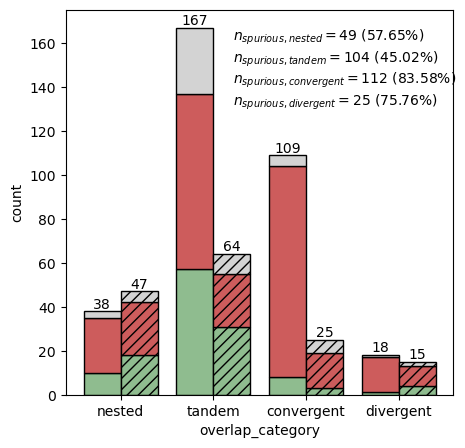

In [334]:
def figure(results_df:pd.DataFrame):
    figure_df = results_df[is_cds_conflict(results_df)].copy()

    fig, ax = plt.subplots(figsize=(5, 5))
    palette = {'real':'darkseagreen', 'spurious':'indianred', 'uncertain':'lightgray'}
    overlap_types = figure_df.overlap_type.unique()
    positions = np.arange(len(overlap_types))
    width = 0.4

    def panel_a(ax_df:pd.DataFrame, offset:float=None, hatch=None, add_label:bool=True):
        totals =  np.zeros(len(overlap_types))
        bottom = np.zeros(len(overlap_types))
        for model_label, df in ax_df.groupby('model_label'):
            heights = [(df.overlap_type == overlap_type).sum() for overlap_type in overlap_types]
            ax.bar(positions + offset, heights, bottom=bottom, edgecolor='black', label=model_label if add_label else '', color=palette[model_label], width=width, hatch=hatch, )
            bottom += np.array(heights)
            totals += heights
        for x, y in zip(positions + offset, totals):
            ax.text(x, y, str(int(y)), ha='center', va='bottom')

    panel_a(figure_df[~figure_df.top_hit_hypothetical], offset=-width/2)
    panel_a(figure_df[figure_df.top_hit_hypothetical], offset=width/2, hatch='///', add_label=False)
    ax.set_xticks(positions, labels=overlap_types)
    ax.set_ylabel('count')
    ax.set_xlabel('overlap_category')

    text = ''
    for category in ['nested', 'tandem', 'convergent', 'divergent']:
        n = ((figure_df.overlap_type == category) & (figure_df.spurious)).sum()
        text += '$n_{spurious,' + category + '}=$' + str(n) + f' ({get_percent(n, (figure_df.overlap_type == category).sum())})'  + '\n'
    ax.text(0.43, 0.7, text, transform=ax.transAxes)

    plt.show()


figure(results_df)

In [597]:
df = results_df[is_antiparallel_cds_conflict(results_df) & (results_df.overlap_type == 'divergent')].copy()
# df = results_df[is_antiparallel_cds_conflict(results_df)].copy()

df[((df.top_hit_product != 'hypothetical protein') & (df.overlap_length > 200))][['top_hit_model_label', 'top_hit_overlap_fraction', 'model_label', 'query_overlap_fraction', 'length', 'overlap_length']]
df[((df.top_hit_product != 'hypothetical protein') & (df.query_overlap_fraction > 0.25))][['top_hit_model_label', 'top_hit_overlap_fraction', 'model_label', 'query_overlap_fraction', 'length', 'overlap_length']]
df[((df.top_hit_product != 'hypothetical protein') & (df.query_overlap_fraction > 0.25))].model_label.value_counts()

model_label
spurious    12
Name: count, dtype: int64

In [ ]:
def si_table(results_df:pd.DataFrame, remove_hypothetical:bool=False):
    
    results_df = results_df[results_df.model_label != 'uncertain'].copy()


    # columns = ['nested', 'nested_tandem', 'tandem', 'nested_antiparallel', 'antiparallel']
    columns = ['nested', 'nested_tandem', 'nested_antiparallel']
    variables = ['same_strand', 'top_hit_hypothetical', 'phase', 'smorf', 'same_strand',  'query_nested', 'host_overlap_fraction']

    results_df['query_nested'] = results_df.query_length < results_df.top_hit_length
    results_df['smorf'] = results_df.length < 100
    results_df['host_overlap_fraction'] =  (np.min(results_df[['query_length', 'top_hit_length']], axis=1) / np.max(results_df[['query_length', 'top_hit_length']], axis=1)) > 0.5
    if remove_hypothetical:
        results_df = results_df[results_df.top_hit_product != 'hypothetical protein'].copy()
        variables.remove('top_hit_hypothetical')

    masks = dict()
    masks['nested'] = is_cds_conflict(results_df) & (results_df.overlap_type == 'nested')
    masks['nested_tandem'] = is_cds_conflict(results_df) & (results_df.overlap_type == 'nested') & results_df.same_strand
    masks['nested_antiparallel'] = is_cds_conflict(results_df) & (results_df.overlap_type == 'nested') & ~results_df.same_strand
    masks['antiparallel'] = is_cds_conflict(results_df) & (results_df.overlap_type.isin(['convergent', 'divergent']))
    masks['tandem'] = is_cds_conflict(results_df) & (results_df.overlap_type == 'tandem') 
    
    # https://pmc.ncbi.nlm.nih.gov/articles/PMC6099145/
    table_df = pd.DataFrame(columns=columns)

    def add_column(df:pd.DataFrame, field:str=None, variables:list=None):
        for variable in variables:
            # If the variable has no effect on the label, then 
            observed_counts_df = pd.crosstab(df[variable], results_df['model_label'])
            # Not sure if I should be testing for independence, or using the null that they are equally-distributed. 
            # expected_counts_df = pd.DataFrame(0.5, index=observed_counts_df.index, columns=observed_counts_df.columns)
            # expected_counts_df = expected_counts_df.mul(totals, axis=0)
            expected_counts_df = pd.DataFrame(expected_freq(observed_counts_df), index=observed_counts_df.index, columns=observed_counts_df.columns) # This uses frequencies based on the marginal frequencies.
            table_df.loc[variable, field] = chisquare(observed_counts_df.values.ravel(), expected_counts_df.values.ravel()).pvalue * len(variables) # Apply the Bonferroni correction. 

    for field in columns:
        mask = masks[field]
        add_column(results_df.copy(), field=field, variables=[var for var in variables if (var != 'query_nested')] if not field.startswith('nested') else variables)
        variables = [var for var in variables if (var != 'same_strand')]

    table_df = table_df.sort_values('nested', ascending=True)
    table_df = table_df.rename(columns={field:f'{field} (n={mask.sum()})' for field, mask in masks.items()})

    return table_df

    
si_table(results_df, remove_hypothetical=False)



,nested (n=77),nested_tandem (n=26),nested_antiparallel (n=51)
same_strand,0.017775,NaN,NaN
host_overlap_fraction,1.258913,0.681605,4.863874
smorf,1.510367,0.147151,4.997691
phase,4.23672,4.60588,2.716969
top_hit_hypothetical,4.483987,4.60588,0.100914
query_nested,5.315848,4.624948,3.0815


In [543]:
def get_nested_results_df(results_df):
    results_df = results_df[is_cds_conflict(results_df) & (results_df.overlap_type == 'nested')].copy()

    df = pd.DataFrame(index=results_df.index)
    df['query_nested'] = results_df.query_length < results_df.top_hit_length
    df['parent_length'] = np.where(df.query_nested, results_df.top_hit_length, results_df.query_length)
    df['daughter_length'] = np.where(~df.query_nested, results_df.top_hit_length, results_df.query_length)
    df['parent_model_label'] = np.where(df.query_nested, results_df.top_hit_model_label, results_df.model_label)
    df['daughter_model_label'] = np.where(~df.query_nested, results_df.top_hit_model_label, results_df.model_label)
    df['daughter_real'] = df.daughter_model_label == 'real'
    df['daughter_spurious'] = df.daughter_model_label == 'spurious'
    df['parent_real'] = df.parent_model_label == 'real'
    df['parent_spurious'] = df.parent_model_label == 'spurious'
    df['parent_overlap_fraction'] = df.daughter_length / df.parent_length
    df['parent_hypothetical'] =  np.where(df.query_nested, results_df.top_hit_product == 'hypothetical protein', True) 
    df['daughter_hypothetical'] =  np.where(~df.query_nested, results_df.top_hit_product == 'hypothetical protein', True) 
    df['same_strand'] = results_df.same_strand
    df['daughter_id'] = np.where(df.query_nested, results_df.index, results_df.top_hit_protein_id) 
    df['parent_id'] = np.where(~df.query_nested, results_df.index, results_df.top_hit_protein_id) 
    df['parent_product'] = np.where(df.query_nested, results_df.top_hit_product, 'hypothetical protein') 
    df['daughter_product'] = np.where(~df.query_nested, results_df.top_hit_product, 'hypothetical protein') 
    
    return df 

# Seems more straightforward to look at things as parent vs. daughter genes in a nested pair. 

In [ ]:
df[(df.parent_model_label == 'real') & (df.daughter_model_label == 'real')].same_strand.value_counts()
df[(df.parent_model_label == 'spurious') & (df.daughter_model_label == 'spurious')].same_strand.value_counts()

# Most of the host-daughter gene pairs are on opposite strands. 
# There are only 9 cases where both the daughter and parent gene are classified as real, and they are all on the same strand. 
# There are 13 cases where both daughter and parent genes are classified as spurious, 8 are on the opposite strand and 5 are on the opposite strand. 
# Two annotated genes are marked as spurious, one is a transposase (parent), and the other is an ATP binding protein (daughter)
# 31 parent genes are annotated, and 7 daughter genes are annotated. 

df[(~df.parent_hypothetical & df.parent_spurious) | (~df.daughter_hypothetical & df.daughter_spurious)]

,query_nested,parent_length,daughter_length,parent_model_label,daughter_model_label,daughter_real,daughter_spurious,parent_real,parent_spurious,parent_overlap_fraction,parent_hypothetical,daughter_hypothetical,same_strand,daughter_id,parent_id,parent_product,daughter_product
id,,,,,,,,,,,,,,,,,
NZ_CP065383.1_53,False,109,30,uncertain,spurious,False,True,False,False,0.275229,True,False,True,WP_218113377.1,NZ_CP065383.1_53,hypothetical protein,ATP-binding protein
NZ_AP025523.1_685,True,87,35,spurious,spurious,False,True,False,True,0.402299,False,True,False,NZ_AP025523.1_685,WP_405054913.1,IS3 family transposase,hypothetical protein


In [532]:
df = get_nested_results_df(results_df)
df['parent_overlap_fraction'] = df.parent_overlap_fraction > 0.5
df['daughter_smorf'] = df.daughter_length < 100
df['parent_smorf'] = df.parent_length < 100

variables = ['same_strand', 'parent_overlap_fraction', 'parent_hypothetical', 'daughter_smorf', 'parent_smorf']
for variable in variables:
    observed_counts_df = pd.crosstab(df[variable], df['daughter_model_label'])
    # observed_counts_df = pd.crosstab(df[variable], df['daughter_model_label'])
    expected_counts_df = pd.DataFrame(expected_freq(observed_counts_df), index=observed_counts_df.index, columns=observed_counts_df.columns) # This uses frequencies based on the marginal frequencies.
    p = chisquare(observed_counts_df.values.ravel(), expected_counts_df.values.ravel()).pvalue * len(variables)
    print(variable, p)
    # table_df.loc[variable, field] =  # Apply the Bonferroni correction. 

# Why would daughter sequences which make up smaller portions of the parent sequence be less likely to be spurious? 
# My first guess would be length, but this seems to have a much smaller effect. My second guess is that a smaller overlap fraction 
# implies that the parent sequence is longer, and therefore less likely to be spurious. 

# Nearly all of the daughter sequences are hypothetical, only 5 are annotated. This implies that pretty much all of the annotated 
# sequences are parents. 

# It's really hard to get anything meaningful out of the nested sequence analysis, as so many are hypothetical.


same_strand 1.0348552706916552
parent_overlap_fraction 0.14677893292576735
parent_hypothetical 4.252797967914966
daughter_smorf 1.4796186535828877
parent_smorf 2.008361918003581


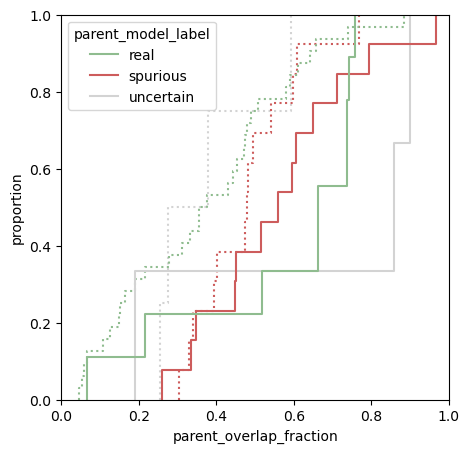

In [523]:
# When the top hit is completely nested, it is more likely that the overlap is due to query N-terminal extension (if both genes are indeed valid).
# In this case, the increased double-coding signal would present in the query embedding, not the top-hit embedding.

def figure(results_df:pd.DataFrame):
    df = get_nested_results_df(results_df)

    # df = df[df.model_label != 'uncertain'].copy()

    fig, ax = plt.subplots(figsize=(5, 5))

    palette = {'real':'darkseagreen', 'spurious':'indianred', 'uncertain':'lightgray'}
    # sns.ecdfplot(df[df.daughter_hypothetical], x='parent_overlap_fraction', hue='parent_model_label', palette=palette, ls=':')
    # sns.ecdfplot(df[~df.daughter_hypothetical], x='parent_overlap_fraction', hue='parent_model_label', palette=palette)
    sns.ecdfplot(df[df.daughter_spurious], x='parent_overlap_fraction', hue='parent_model_label', palette=palette, ls=':')
    sns.ecdfplot(df[df.daughter_real], x='parent_overlap_fraction', hue='parent_model_label', palette=palette)

    ax.set_xlim(xmin=0, xmax=1)
    ax.set_ylabel('proportion')
    plt.show()

    # The Prodigal sequence is nested in 56 of the 85 nested overlaps

    return df

df = figure(results_df)
# df[(df.parent_model_label == 'real') & (df.daughter_model_label == 'real')][['parent_overlap_fraction']]



In [ ]:
# Might be good to take a closer look at the antiparallel-conflicting proteins predicted to be real with high confidence.
# There are too many spurious predictions to look at in any depth. 

df = results_df[is_antiparallel_cds_conflict(results_df) & results_df.real].copy()

n_hypothetical = (df.top_hit_product != 'hypothetical protein').sum()
n_unsupported = ((df.top_hit_product == 'hypothetical protein') & (df.top_hit_evidence_type == 'ab initio prediction')).sum()

print('Num. real-predicted antiparallel conflicts with hypothetical proteins:', n_hypothetical, f'({get_percent(n_hypothetical, len(df))})')
print('Num. real-predicted antiparallel conflicts with unsupported proteins:', n_unsupported, f'({get_percent(n_unsupported, len(df))})')

for overlap_type in ['divergent', 'convergent']:
    n_hypothetical = ((df.top_hit_product != 'hypothetical protein') & (df.overlap_type == overlap_type)).sum()
    n_unsupported = ((df.top_hit_product == 'hypothetical protein') & (df.top_hit_evidence_type == 'ab initio prediction') & (df.overlap_type == overlap_type)).sum()

    print(f'\nNum. real-predicted {overlap_type} conflicts with hypothetical proteins:', n_hypothetical, f'({get_percent(n_hypothetical, (df.overlap_type == overlap_type).sum())})')
    print(f'Num. real-predicted {overlap_type} conflicts with unsupported proteins:', n_unsupported, f'({get_percent(n_unsupported, (df.overlap_type == overlap_type).sum())})')

columns = ['species', 'genome_id', 'top_hit_protein_id', 'top_hit_product', 'top_hit_evidence_type', 'phase', 'length', 'top_hit_length', 'overlap_length', 'spans_assembly_gap', 'overlap_type']
df['spans_assembly_gap'] = df.seq.str.count('X') > 2
df[columns].to_csv('../data/results/results-2/antiparallel_real.csv')

# Export the Prodigal-predicted and reference sequences for InterPro annotation and BLAST alignment.
content = ''
for row in df.itertuples():
    seq = re.sub('X{2,}', '', row.seq)
    content += f'>{row.Index}\n{seq}\n'
    content += f'>{row.top_hit_protein_id}\n{row.top_hit_seq}\n'
with open('../data/results/results-2/antiparallel_real.faa', 'w') as f:
    f.write(content)

# pd.crosstab(df.overlap_type, df.phase)

Num. real-predicted antiparallel conflicts with hypothetical proteins: 9 (56.25%)
Num. real-predicted antiparallel conflicts with unsupported proteins: 6 (37.50%)

Num. real-predicted divergent conflicts with hypothetical proteins: 1 (20.00%)
Num. real-predicted divergent conflicts with unsupported proteins: 4 (80.00%)

Num. real-predicted convergent conflicts with hypothetical proteins: 8 (72.73%)
Num. real-predicted convergent conflicts with unsupported proteins: 2 (18.18%)


p=0.2992002026233293


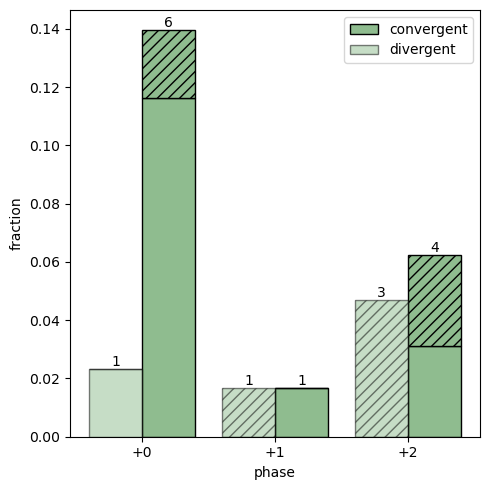

In [446]:
def si_figure(results_df:pd.DataFrame, model_label:str='real', text_position=(0.1, 0.7), normalize:bool=True):

    fig, ax = plt.subplots(figsize=(5, 5))
    
    alphas = {'convergent':1, 'divergent':0.5}
    color = 'indianred' if (model_label == 'spurious') else 'darkseagreen'

    figure_df = results_df[is_antiparallel_cds_conflict(results_df)].copy()
    phases = sorted(figure_df.phase.unique())
    totals = figure_df.phase.value_counts().loc[phases].values 

    p = get_chi_square_p_value(pd.crosstab(figure_df['phase'], figure_df['model_label']))
    print(f'p={p}')

    width = 0.4 
    positions = np.arange(len(phases))
    offsets = {'convergent': width / 2, 'divergent':-width / 2}
    hatches = {True:'///', False:None}

    totals = np.array([((figure_df.phase == phase)).sum() for phase in phases])

    def panel(ax_df:pd.DataFrame, offset:float=None, ax:plt.Axes=None, label:str=None, bottom=np.zeros(len(phases))):

        counts_ = np.zeros(len(phases))

        for top_hit_hypothetical, df in ax_df.groupby('top_hit_hypothetical'):
            counts = np.array([((df.phase == phase) & (df.model_label == model_label)).sum() for phase in phases])
            counts_ += counts 
            # totals = np.array([((df.phase == phase)).sum() for phase in phases])
            heights = counts / totals 
            ax.bar(positions + offset, heights, bottom=bottom, color=color, hatch=hatches[top_hit_hypothetical], edgecolor='black', width=width, label=label if (not top_hit_hypothetical) else None, alpha=alphas[label])
            bottom += heights 

        for x, y, n in zip(positions + offset, bottom, counts_):
            ax.text(x, y, str(int(n)), ha='center', va='bottom')

    for overlap_type in ['convergent', 'divergent']:
        ax_df = figure_df[(figure_df.overlap_type == overlap_type)].copy()
        panel(ax_df, offset=offsets[overlap_type], label=overlap_type, ax=ax, bottom=np.zeros(len(phases)))


    ax.legend()
    ax.set_xticks(positions, labels=[f'+{int(phase)}' for phase in phases])
    ax.set_xlabel('phase')
    ax.set_ylabel('fraction')

    fig.tight_layout()

si_figure(results_df, model_label='real', text_position=(0.45, 0.65))
# si_figure(results_df, model_label='spurious', text_position=(0.1, 0.65))

In [ ]:
# figure_df = results_df[is_cds_conflict(results_df) & (results_df.overlap_type == 'tandem')].copy()
# figure_df['query_overlap_fraction_bin'] = pd.cut(figure_df.query_overlap_fraction, bins=np.arange(0, 1.1, 0.1), retbins=False, labels=False)
# fig, ax = plt.subplots(figsize=(5, 5))

# ax_df = pd.DataFrame(index=figure_df.query_overlap_fraction_bin.unique())
# ax_df['n_real'] = ax_df.index.map(figure_df.groupby('query_overlap_fraction_bin').real.sum())
# ax_df['n_spurious'] = ax_df.index.map(figure_df.groupby('query_overlap_fraction_bin').spurious.sum())
# ax_df['n_uncertain'] = ax_df.index.map(figure_df.groupby('query_overlap_fraction_bin').uncertain.sum())
# ax_df['total'] = ax_df.index.map(figure_df.groupby('query_overlap_fraction_bin').apply(len, include_groups=False))

# for col in ['n_real', 'n_spurious', 'n_uncertain']:
#     ax_df[col.replace('n_', 'frac_')] = ax_df[col] / ax_df['total']
# ax_df['bin'] = ax_df.index

# sns.lineplot(ax_df, y='frac_real', x='bin', color='darkseagreen', label='real')
# sns.lineplot(ax_df, y='frac_spurious', x='bin', color='indianred', label='spurious')
# sns.lineplot(ax_df, y='frac_uncertain', x='bin', color='lightgray', label='uncertain')
# ax.set_xticks(np.arange(len(np.arange(0, 1, 0.1))), labels=[f'{n:.1f}' for n in np.arange(0, 1, 0.1)])
# ax.set_xlabel('query_overlap_fraction')
# ax.set_ylabel('fraction')
# plt.show()

['model_label', 'model_output_0', 'model_output_1', 'n_hits', 'n_hits_supported', 'n_hits_same_strand', 'n_hits_opposite_strand', 'n_hits_in_frame', 'top_hit_feature', 'top_hit_contig_id', 'top_hit_product', 'top_hit_note', 'top_hit_pseudo', 'top_hit_locus_tag', 'top_hit_inference', 'top_hit_experiment', 'top_hit_ribosomal_slippage', 'top_hit_go_function', 'top_hit_go_process', 'top_hit_continuous', 'top_hit_translation_table', 'top_hit_codon_start', 'top_hit_protein_id', 'top_hit_evidence_type', 'top_hit_evidence_category', 'top_hit_evidence_details', 'top_hit_evidence_source', 'top_hit_used_pgap', 'top_hit_genome_id', 'top_hit_id', 'query_start', 'query_stop', 'query_partial', 'query_strand', 'seq', 'query_gc_content', 'query_rbs_motif', 'query_rbs_spacer', 'query_start_type', 'top_hit_start', 'top_hit_stop', 'top_hit_partial', 'top_hit_strand', 'top_hit_seq', 'top_hit_length', 'query_length', 'same_strand', 'overlap_start', 'overlap_stop', 'overlap_type', 'overlap_length', 'top_hit_

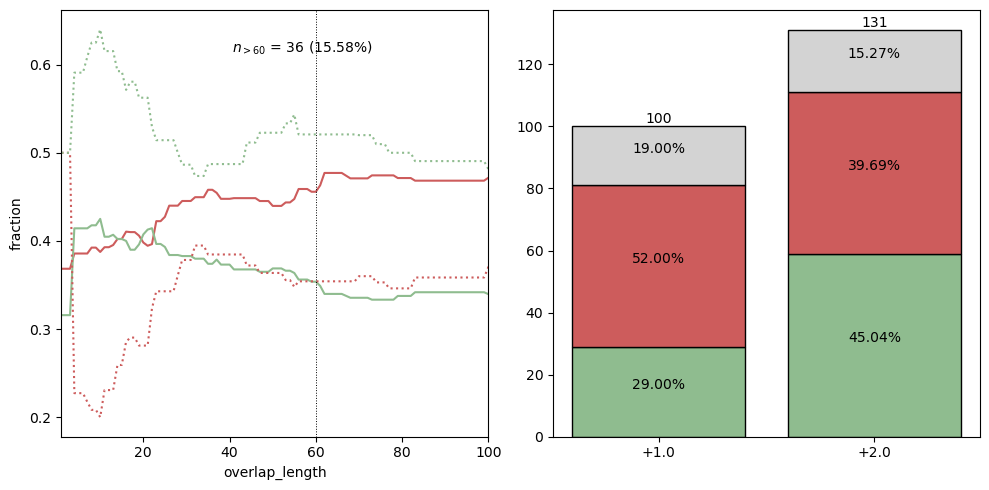

In [411]:
def si_figure(results_df:pd.DataFrame, overlap_length:int=65):

    figure_df = results_df[is_cds_conflict(results_df) & (results_df.overlap_type == 'tandem')].copy()
    # figure_df['phase'] = results_df.overlap_length % 3
    figure_df = figure_df[figure_df.phase != 0].copy()
    print(figure_df.columns.tolist())

    # The majority of tandem overlaps have fewer than 60 bp in conflict (as many are detected by Prodigal)
    fig, (ax_a, ax_c) = plt.subplots(figsize=(10, 5), ncols=2)
    palette = {'real':'darkseagreen', 'spurious':'indianred', 'uncertain':'lightgray'}

    # def panel_a(ax_df:pd.DataFrame, ax=None):
    #     sns.ecdfplot(ax_df, hue='model_label', palette=palette, ax=ax, x='overlap_length')
    #     ax.set_xlim(xmax=100, xmin=0)

    #     text = ''
    #     for model_label, df in ax_df.groupby('model_label'):
    #         n = (df.overlap_length > overlap_length).sum()
    #         text += '$p_{' + model_label + '>' + str(overlap_length) + '}$' + f' = {get_percent(n, len(df))} ($n={n}$)\n'
    #     ax.text(0.25, 0.1, text, transform=ax.transAxes, fontsize='small')
    #     ax.axvline(x=overlap_length, color='black', ls='--', lw=0.5)
    #     ax.axvline(x=4, color='black', ls='--', lw=0.5, zorder=-1)
    #     ax.text(4, 1.01, '+4', fontsize='x-small', ha='center')
    #     ax.text(1, 1.01, '+1', fontsize='x-small', ha='center')
    #     ax.axvline(x=1, color='black', ls='--', lw=0.5, zorder=-1)
    #     ax.set_ylabel('proportion')
    #     sns.move_legend(ax, loc='upper left')

    def panel_a(figure_df:pd.DataFrame, ax:plt.Axes=None, linestyle:str='-'):
        min_overlap_length = figure_df.overlap_length.min()
        overlap_lengths = np.arange(min_overlap_length, 400)

        ax_df = pd.DataFrame(index=overlap_lengths, columns=['uncertain', 'real', 'spurious', 'hypothetical'])
        ax_df['overlap_length'] = overlap_lengths

        for overlap_length in overlap_lengths:
            df = figure_df[figure_df.overlap_length <= overlap_length]
            # df = figure_df[(figure_df.overlap_length <= overlap_length + delta) & (figure_df.overlap_length >= overlap_length - delta)]
            # if len(df) > 0:
            ax_df.loc[overlap_length, 'spurious'] = df.spurious.sum() / len(df)
            # ax_df.loc[overlap_length, 'uncertain'] = df.uncertain.sum() / len(df)
            ax_df.loc[overlap_length, 'real'] = df.real.sum() / len(df)
        sns.lineplot(data=ax_df[~ax_df.spurious.isnull()], x='overlap_length', y='spurious', color='indianred', ax=ax, linestyle=linestyle)
        sns.lineplot(data=ax_df[~ax_df.real.isnull()], x='overlap_length', y='real', color='darkseagreen', ax=ax, linestyle=linestyle)

        ax.set_ylabel('fraction')
        ax.set_xlim(xmax=100, xmin=1)

    def panel_c(ax_df:pd.DataFrame, ax=None):
        phases = sorted(figure_df.phase.unique())
        # ax_df = ax_df[ax_df.overlap_length > 7]

        positions = np.arange(len(phases))
        totals = ax_df.groupby('phase').apply(len, include_groups=False).loc[phases]
        bottom = np.zeros(len(phases))

        for model_label, df in ax_df.groupby('model_label'):
            heights = np.array([(df.phase == phase).sum() for phase in phases])
            ax.bar(positions, heights, bottom=bottom, edgecolor='black', label=model_label, color=palette[model_label])
            for x, y, n, total in zip(positions, bottom + heights / 2, heights, totals):
                if n > 5:
                    ax.text(x, y, get_percent(n, total), ha='center', va='bottom')
            bottom += np.array(heights)

        for x, y in zip(positions, totals):
            ax.text(x, y, str(int(y)), ha='center', va='bottom')

        ax.set_xticks(np.arange(len(phases)), labels=[f'+{phase}' for phase in phases])
    
    panel_a(figure_df[~figure_df.top_hit_hypothetical].copy(), ax=ax_a)
    panel_a(figure_df[figure_df.top_hit_hypothetical], ax=ax_a, linestyle=':')

    text = '$n_{>60}$ = ' + str((figure_df.overlap_length > 60).sum())
    text += f' ({get_percent((figure_df.overlap_length > 60).sum(), len(figure_df))})'
    ax_a.text(0.4, 0.9, text, transform=ax_a.transAxes)
    ax_a.axvline(60, ls=':', lw=0.7, color='black')

    panel_c(figure_df, ax=ax_c)

    figure_df = figure_df[figure_df.real].copy()
    print('Num. real tandem +1 overlaps:', (figure_df.overlap_length == 1).sum(), f'({get_percent((figure_df.overlap_length == 1).sum(), len(figure_df))})')
    print('Num. real tandem +4 overlaps:', (figure_df.overlap_length == 4).sum(), f'({get_percent((figure_df.overlap_length == 4).sum(), len(figure_df))})')
    print('Num. real tandem phase +1 overlaps:', (figure_df.phase == 1).sum(), f'({get_percent((figure_df.phase == 1).sum(), len(figure_df))})')
    print('Num. real tandem phase +2 overlaps:', (figure_df.phase == 2).sum(), f'({get_percent((figure_df.phase == 2).sum(), len(figure_df))})')

    fig.tight_layout()
    plt.show()

si_figure(results_df)

# Interesting observation that about half of the valid tandem overlaps are predicted to be spurious. 

# In the first panel, we see that real-predicted sequences tend to have shorter overlaps. However, 
# past about 60 bp, the overlap length effect seems to largely disappear. Notably, 60 bp is the maximum tandem 
# overlap length allowed by Prodigal.

In [619]:
model_label = 'spurious'
df = results_df[is_cds_conflict(results_df) & (results_df.overlap_type == 'tandem') & (results_df.overlap_length > 60) & results_df[model_label]].copy()

is_overlap_at_query_n_terminus = lambda row : ((row.query_strand == 1) and (row.query_overlap == '10')) or ((row.query_strand == -1) and (row.query_overlap == '01'))
is_overlap_at_top_hit_n_terminus = lambda row : ((row.top_hit_strand == 1) and (row.top_hit_overlap == '10')) or ((row.top_hit_strand == -1) and (row.top_hit_overlap == '01'))
df['query_overlap_at_n_terminus'] = df.apply(is_overlap_at_query_n_terminus, axis=1)
df['top_hit_overlap_at_n_terminus'] = df.apply(is_overlap_at_top_hit_n_terminus, axis=1)
df['most_common_rbs_motif'] = df.genome_id.map(most_common_rbs_motifs)

columns = ['species', 'genome_id', 'top_hit_protein_id', 'top_hit_product', 'top_hit_evidence_type', 'query_overlap_at_n_terminus', 'length', 'top_hit_length', 'overlap_length', 'top_hit_spurious', 'query_rbs_motif', 'most_common_rbs_motif']
df[columns].to_csv(f'../data/results/results-2/tandem_{model_label}.csv')

# Export the Prodigal-predicted and reference sequences for InterPro annotation and BLAST alignment.
content = ''
for row in df.itertuples():
    seq = re.sub('X{2,}', '', row.seq)
    content += f'>{row.Index}\n{seq}\n'
    content += f'>{row.top_hit_protein_id}\n{row.top_hit_seq}\n'
with open(f'../data/results/results-2/tandem_{model_label}.faa', 'w') as f:
    f.write(content)


In [624]:
df = results_df[is_cds_conflict(results_df) & (results_df.top_hit_product != 'hypothetical protein') & (results_df.query_overlap_fraction > 0.5)].copy()
df[df.real].top_hit_evidence_type.value_counts()

top_hit_evidence_type
similar to AA sequence    7
protein motif             3
ab initio prediction      1
Name: count, dtype: int64

In [615]:
results_df[results_df.spurious & is_non_coding_conflict(results_df)].query_rbs_motif.value_counts()

get_most_common_rbs_motif = lambda df : df.query_rbs_motif.value_counts().sort_values(ascending=False).index[0]
most_common_rbs_motifs = results_df.groupby('genome_id').apply(get_most_common_rbs_motif)
most_common_rbs_motifs

/tmp/ipykernel_5745/1510023609.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  most_common_rbs_motifs = results_df.groupby('genome_id').apply(get_most_common_rbs_motif)


genome_id
GCF_000199675.1      GGAG/GAGG
GCF_000212395.1         AGGAGG
GCF_000284335.1         AGGAGG
GCF_000427095.1          AGGAG
GCF_001886815.1    GGA/GAG/AGG
GCF_002973605.1    GGA/GAG/AGG
GCF_003570935.1          GGAGG
GCF_011059105.1            TAA
GCF_015277515.1      GGAG/GAGG
GCF_015775515.1         AGGAGG
GCF_019753795.1         AGGAGG
GCF_027923555.1    GGA/GAG/AGG
GCF_030520105.1         AGGAGG
GCF_034932365.1    GGA/GAG/AGG
GCF_041154365.1    GGA/GAG/AGG
GCF_900070205.1    GGA/GAG/AGG
GCF_946900835.1    GGA/GAG/AGG
dtype: object

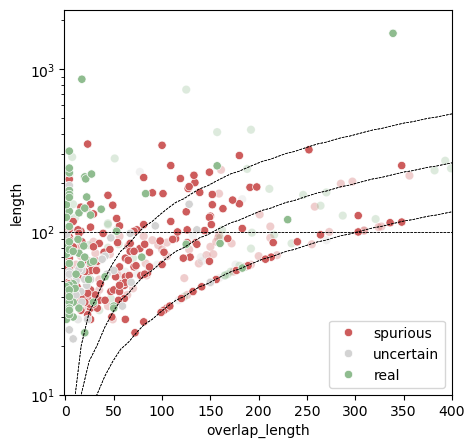

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

figure_df = results_df[is_cds_conflict(results_df)].copy()

palette = {'real':'darkseagreen', 'spurious':'indianred', 'uncertain':'lightgray'}

def panel_b(ax_df:pd.DataFrame, ax=None, hypothetical:bool=False):
    ax_df = ax_df.sort_values('model_output_1')
    sns.scatterplot(ax_df, hue='model_label', palette=palette, ax=ax, x='overlap_length', y='length', alpha=0.3 if hypothetical else 1, legend=not hypothetical)
    # sns.move_legend(ax, loc='upper left')
    ax.set_xlim(xmax=400)
    ax.set_yscale('log')
    # ax_a.set_ylim(ymax=300)
    
    # ax.axvline(x=overlap_length, color='black', ls='--', lw=0.5)
    ax.axhline(y=100, color='black', ls='--', lw=0.5)
    
    for overlap_fraction in [0.25, 0.5, 1]:
        x = np.linspace(0, 400, 50) # Overlap length. 
        y = (1 / overlap_fraction) * (x // 3)
        sns.lineplot(x=x, y=y, color='black', ls='--', lw=0.5)

panel_b(figure_df[figure_df.top_hit_hypothetical].copy(), ax=ax, hypothetical=True)
panel_b(figure_df[~figure_df.top_hit_hypothetical].copy(), ax=ax)
ax.set_xlim(xmin=-1)
ax.set_ylim(ymin=10)
plt.show()

# NOTE: Worth noting that it is possible that the model is more sensitive to antisense overlap, in which case this problem could be excacerbated in the antiparallel conflicts. 
# It may also be worth checking the spurious-classified antiparallel conflicts with an overlap length exceeding a certain amount. 

# It is also possible that the overlap length effect is not a true reflection of biological constraints, but rather a side-effect of mean-pooling embedding vectors. If double-coding
# regions produce distinct PLM representations, then mean-pooling sequences with large overlap fractions may cause the sequence to resemble a shadow ORF in embedding space. 
# Because several of spurious examples provided in the training data are shadow ORFs, it is likely that the model would classify these sequences as spurious. In most scenarios, 
# this would result in the correct classification, as long CDS overlaps are rare. However, this could be problematic if erroneously-predicted gene boundaries result in artificially-extended overlaps. 
# Furthermore, this would result in the model failing on genuine nested ORFs, as well as gene pairs with unusually large overlapping regions.

# NOTE: 
# However, if this were the case, we would expect that whether or not the query sequence is the host or daughter gene in a nested overlap configuration would have a strong effect on whether or 
# not the query is classified as spurious

# Indeed, the vast majority of sequences with large (> 60 bp) overlap also have a substantial overlap fraction (> 25%), and most of those which conflict with annotated reference sequences are classified as spurious. 
# It is also worth noting that a handful of the false negatives in the training data are experimentally-confirmed nested ORFs (e.g. __). To determine if the model is indeed misclassifying sequences with large
# overlap fractions, we performed further analysis on spurious-classified tandem conflicts with > 60 bp overlap.

# Based on one paper, nearly every tandem overlap exceeding 60 bp is a result of mispredicted gene boundaries, 

In [326]:
df = results_df[is_cds_conflict(results_df) & (results_df.overlap_type == 'nested')].copy()
df['query_nested'] = df.query_length < df.top_hit_length
df['top_hit_nested'] = df.query_length > df.top_hit_length

from src.reference import get_overlap_type

ids = list()

for row in df.itertuples():
    df_ = get_alternate_configurations(row, top_hit=row.query_nested)
    df_['overlap_type'] = [get_overlap_type(query_start=row.start, query_stop=row.stop, subject_start=row.conflict_start, subject_stop=row.conflict_stop, subject_strand=row.conflict_strand, query_strand=row.strand) for row in df_.itertuples()]
    df_ = df_[(df_.start_codon.isin(['AUG', 'GUG'])) & (df_.overlap_type != 'nested') & (df_.length >= 30)].copy()
    if len(df_) > 0:
        ids += [row.Index]

results_df.loc[ids].value_counts(['same_strand', 'model_label'])


same_strand  model_label
False        spurious       21
             real            5
True         real            5
             spurious        5
             uncertain       4
False        uncertain       1
Name: count, dtype: int64

In [432]:
# def si_figure(results_df:pd.DataFrame, model_label:str='real', text_position=(0.1, 0.7)):

#     fig, ax = plt.subplots(figsize=(5, 5))

#     # palettes = {'real':{'convergent':'darkseagreen', 'divergent':'seagreen'}, 'spurious':{'convergent':'indianred', 'divergent':'firebrick'}}
#     alphas = {'convergent':1, 'divergent':0.5}
#     color = 'indianred' if (model_label == 'spurious') else 'darkseagreen'

#     figure_df = results_df[is_antiparallel_cds_conflict(results_df)].copy()
#     phases = sorted(figure_df.phase.unique())
#     totals = figure_df.phase.value_counts().loc[phases].values 

#     p = get_chi_square_p_value(pd.crosstab(figure_df['phase'], figure_df['model_label']))
#     print(f'p={p}')
#     figure_df = figure_df[figure_df.model_label == model_label].copy()

#     width = 0.4 
#     # palette = palettes[model_label]
#     positions = np.arange(len(phases))
#     offsets = {'convergent': width / 2, 'divergent':-width / 2}
#     hatches = {True:'///', False:None}

#     def panel(ax_df:pd.DataFrame, offset:float=None, ax:plt.Axes=None, label:str=None, bottom=np.zeros(len(phases))):
#         for top_hit_hypothetical, df in ax_df.groupby('top_hit_hypothetical'):
#             heights = np.array([((df.phase == phase)).sum() for phase in phases])
#             ax.bar(positions + offset, heights, bottom=bottom, color=color, hatch=hatches[top_hit_hypothetical], edgecolor='black', width=width, label=label if (not top_hit_hypothetical) else None, alpha=alphas[label])
#             bottom += heights 
#         return bottom

#     for overlap_type in ['convergent', 'divergent']:
#         ax_df = figure_df[(figure_df.overlap_type == overlap_type)].copy()
#         panel(ax_df, offset=offsets[overlap_type], label=overlap_type, ax=ax, bottom=np.zeros(len(phases)))

#     text = ''
#     for i, n in enumerate(figure_df.phase.value_counts().loc[phases].values):
#         text += '$n_{' + f'+{int(i)}' + '}' + f'={n}$ ({get_percent(n, totals[i])})\n'
#     # ax.text(0.35, 0.8, text, transform=ax.transAxes)
#     ax.text(*text_position, text, transform=ax.transAxes)

#     ax.legend()
#     ax.set_xticks(positions, labels=[f'+{int(phase)}' for phase in phases])
#     ax.set_xlabel('phase')
#     ax.set_ylabel('count')

#     fig.tight_layout()

# si_figure(results_df, model_label='real', text_position=(0.45, 0.65))
# si_figure(results_df, model_label='spurious', text_position=(0.1, 0.65))

In [ ]:
# # TODO: Compute and report Mann-Whitney test statistics for the ECDF curve differences. 
# # TODO: Should I mention the fact that overlap length is confounded by overlap orientation?
# # TODO: Statistical test showing differences in the antisense vs. sense composition of spurious- and real-labeled sequences. 
# # "Because antisense conflicts are generally larger than sense conflicts (SI Figure 3.2.2), it is unclear if overlap length is itself significant, 
# # or if the observed difference is a byproduct of model sensitivity to antisense overlap."

# def si_figure_3(results_df:pd.DataFrame):
#     '''
#     (A) A summary of model predictions on conflicting sequences; the fraction of antisense conflicts in each category is indicated by the hatched fill. 
#     Spurious-labeled sequences conflicting with supported CDS are significantly more likely to overlap on the antisense strand (p < 1e-11) than their real-labeled counterparts.
#     This effect is far less pronounced for sequences conflicting with unsupported CDS (p > 1e-2).
    
#     (B) ECDF curves of the overlap lengths for conflicts with supported (solid lines) and unsupported (dashed lines) CDS; p_spurious and p_real 
#     are the percentages of conflicts with supported CDS which exceed 10 amino acids in length. Spurious-labeled sequences conflicting with supported CDS have substantially larger
#     overlaps than their real-labeled counterparts. Interestingly, there is no significant difference in the ECDF curves of spurious- and real-classified sequences in conflict with
#     unsupported CDS. The results presented in (A) and (B) suggest that the model is not sensitive to conflict with unsupported CDS.'''

#     figure_df = results_df[results_df.conflict][['top_hit_feature', 'same_strand', 'model_label', 'top_hit_hypothetical', 'overlap_length', 'antifam_hit', 'query_overlap_fraction']].copy()
#     figure_df['conflict_with_cds'] = figure_df.top_hit_feature == 'CDS'
#     figure_df['conflict_with_unsupported_cds'] = (figure_df.top_hit_feature == 'CDS') & (figure_df.top_hit_hypothetical)
#     figure_df['conflict_with_confirmed_cds'] = (figure_df.top_hit_feature == 'CDS') & (~figure_df.top_hit_hypothetical)
#     figure_df['conflict_with_non_coding'] = ~figure_df.conflict_with_cds

#     fig, (ax_a, ax_b) = plt.subplots(figsize=(10, 5), ncols=2)

#     width = 0.4
#     offsets = {'real': -width/2, 'spurious':width/2}

#     ax_a_df = figure_df.copy()
#     categories = ['confirmed_cds', 'unsupported_cds', 'non_coding']
#     conditions = [ax_a_df.conflict_with_confirmed_cds, ax_a_df.conflict_with_unsupported_cds, ax_a_df.conflict_with_non_coding]
#     ax_a_df['category'] = np.select(conditions, categories, default='none')
#     ax_a_df['model_label'] = np.where(ax_a_df.model_label == 1, 'real', 'spurious')

#     palette = {'real':'darkseagreen', 'spurious':'indianred'}
#     for model_label, df in ax_a_df.groupby('model_label'):
#         ax_df = pd.DataFrame(index=categories)
#         ax_df['total'] = df.category.value_counts()
#         ax_df['fraction'] = df.groupby('category', observed=True).apply(lambda df : (df.same_strand).sum() / len(df), include_groups=False)
#         ax_df['same_strand'] = ax_df['total'] * ax_df['fraction']
#         ax_df['opposite_strand'] = ax_df['total'] * (1 - ax_df['fraction'])
#         positions = np.arange(ax_a_df.category.nunique())
#         ax_a.bar(positions + offsets[model_label], ax_df.opposite_strand,color=palette[model_label], edgecolor='black', hatch='//', width=width)
#         ax_a.bar(positions + offsets[model_label], ax_df.same_strand, bottom=ax_df.opposite_strand, color=palette[model_label], edgecolor='black', width=width)

#         for x, total in zip(positions + offsets[model_label], ax_df.total):
#             text = total
#             ax_a.text(x, total, text, ha='center', fontsize='small', va='bottom')

#     ax_a.set_xticks(positions, labels=ax_df.index)
#     ax_a.set_ylabel('count')

#     text = ''
#     for category, df in ax_a_df.groupby('category'):
#         n = (df.model_label == 'spurious').sum()
#         category = category.replace('_', ' ').replace('cds', '')
#         text += '$p_{' + category + '}$' + f' = {get_percent(n, len(df))} ($n={n}$)\n'
#     ax_a.text(0.5, 0.7, text, transform=ax_a.transAxes, fontsize='small')


#     ax_b_df = figure_df[figure_df.conflict_with_cds].copy()
#     ax_b_df['overlap_length'] = ax_b_df.overlap_length // 3 # Convert to units of amino acids. 
#     ax_b_df['model_label'] = np.where(ax_b_df.model_label == 0, 'spurious', 'real')
#     palette = {'real':'darkseagreen', 'spurious':'indianred'}
#     sns.ecdfplot(ax=ax_b, data=ax_b_df[ax_b_df.top_hit_hypothetical], hue='model_label', x='overlap_length', palette=palette, ls=':')
#     sns.ecdfplot(ax=ax_b, data=ax_b_df[~ax_b_df.top_hit_hypothetical], hue='model_label', x='overlap_length', palette=palette)

#     text = ''
#     overlap_length = 10
#     for model_label, df in ax_b_df[~ax_b_df.top_hit_hypothetical].groupby('model_label'):
#         n_overlap_greater_than = (df.overlap_length > overlap_length).sum()
#         text += '$p_{' + model_label + '>' + str(overlap_length) + '}$' + f' = {get_percent(n_overlap_greater_than, len(df))} ($n={n_overlap_greater_than}$)\n'
#     ax_b.text(0.5, 0.5, text, transform=ax_b.transAxes, fontsize='small')
#     ax_b.axvline(x=overlap_length, ls='--', color='black', lw=0.5)

#     ax_b.set_xlim(xmax=200, xmin=0)
#     ax_b.set_title('CDS overlap')
#     ax_b.set_ylabel('proportion')

#     fig.tight_layout()
#     plt.show()

# # Could add some annotation to panel A... What summary statistics might be helpful?
# si_figure_3(results_df)

In [ ]:
    # for same_strand, df in figure_df.groupby('same_strand'):
    #     ax_a_df = pd.DataFrame(index=categories)
    #     ax_a_df['total'] = df.category.value_counts()
    #     ax_a_df['log_total'] = np.log10(ax_a_df['total'] + 0.5)
    #     ax_a_df['fraction'] = df.groupby('category').apply(lambda df : df.top_hit_hypothetical.sum() / len(df), include_groups=False)
    #     ax_a_df['unsupported'] = ax_a_df['log_total'] * ax_a_df['fraction']
    #     ax_a_df['supported'] = ax_a_df['log_total'] * (1 - ax_a_df['fraction'])

    #     ax_a.bar(positions + offsets[same_strand], ax_a_df.unsupported, color=palette[same_strand], edgecolor='black', hatch='///', width=width)
    #     ax_a.bar(positions + offsets[same_strand], ax_a_df.supported, bottom=ax_a_df.unsupported, color=palette[same_strand], edgecolor='black', width=width)
        
    #     for x, total, log_total in zip(positions + offsets[same_strand], ax_a_df.total, ax_a_df.log_total):
    #         # text = f'{100 * total / ax_a_df.total.sum():.2f}%'
    #         text = str(total)
    #         ax_a.text(x, log_total, text, ha='center', fontsize='small', va='bottom')

In [ ]:
# is_partial_at_c_terminus = lambda strand, partial : ((partial[0] == '1')) and (strand == -1) or ((partial[-1] == '1') and (strand == 1))
# is_partial_at_n_terminus = lambda strand, partial : ((partial[0] == '1')) and (strand == 1) or ((partial[-1] == '1') and (strand == -1))

# is_query_partial_at_c_terminus = lambda row : is_partial_at_c_terminus(row.query_strand, row.query_partial)
# is_top_hit_partial_at_n_terminus = lambda row : ((row.top_hit_partial == '01') and (row.top_hit_strand == 1)) or ((row.top_hit_partial == '10') and (row.top_hit_strand == -1))
# is_top_hit_cds = lambda row : (row.top_hit_feature == 'CDS') and not row.top_hit_pseudo

# # Overlaps greater than 60 bp are almost certainly spurious. However, the proteins could still be in-frame with a genuine ORF, and the 
# # overlap may be the result of a boundary error. Sequences can be extended at the N-terminus due to erroneous start-codon selection, or extended 
# # at the C-terminus due to a frameshift mutation. N-terminal extensions are the most common cause of overlap, and also the simplest to detect, 
# # so will probably limit analysis to these. 

# # Conflicts that are potentially the result of N-terminal extension include:
# # (1) Divergent overlaps where one or both sequence coordinates are the product of ab initio prediction. 
# # (2) Tandem overlaps where the downstream sequence coordinates are the product of ab initio prediction. 
# # (2) Nested overlaps where one or both sequence coordinates are the product of ab initio prediction. 

# query_start_in_top_hit = lambda df : (df.query_start <= df.top_hit_stop) & (df.query_start >= df.top_hit_start)
# query_stop_in_top_hit = lambda df : (df.query_stop <= df.top_hit_stop) & (df.query_stop >= df.top_hit_start)
# top_hit_start_in_query = lambda df : (df.top_hit_start <= df.query_stop) & (df.top_hit_start >= df.query_start)
# top_hit_stop_in_query = lambda df : (df.top_hit_stop <= df.query_stop) & (df.top_hit_stop >= df.query_start)

# is_conflict_at_query_n_terminus = lambda df : (df.query_strand == 1) & query_start_in_top_hit(df) | ((df.query_strand == -1) & query_stop_in_top_hit(df))
# is_conflict_at_top_hit_n_terminus = lambda df : ((df.top_hit_strand == 1) & top_hit_start_in_query(df) | ((df.top_hit_strand == -1) & top_hit_stop_in_query(df)))

# def get_alternate_coordinates(nt_seq:str=None, start:int=None, stop:int=None, strand:int=None, codon_start:int=1, partial:str=None):
    
#     if nt_seq == 'none':
#         return np.array([start]), np.array([stop])
#     nt_seq = nt_seq[int(codon_start) - 1:]
    
#     start_codons = ['AUG', 'GUG', 'UUG']
#     codons = np.array([nt_seq[i:i + 3] for i in range(0, len(nt_seq) + 1, 3)])
#     start_codon_idxs = np.where(np.isin(codons, start_codons))[0]
#     # WP_259095463.1 does not seem to have a start codon?
#     if len(start_codon_idxs) == 0:
#         return np.array([start]), np.array([stop])
    
#     assert (len(nt_seq) % 3 == 0) or is_partial_at_c_terminus(strand, partial), f'get_alternate_coordinates: Nucleotide sequence length should be divisible by three, got {len(nt_seq)}.'
#     assert len(''.join(codons)) == len(nt_seq), 'get_alternate_coordinates: Joined codons should have the same length as the original nucleotide sequence.'
#     # assert len(start_codon_idxs) >= 1 or is_partial_at_n_terminus(strand, partial), f'get_alternate_starts: Should be at least one start codon. {nt_seq}'

#     start_codon_idxs = 3 * start_codon_idxs

#     if strand == 1:
#         starts = start + start_codon_idxs
#         stops = np.array([stop] * len(starts))
#     elif strand == -1:
#         stops = stop - start_codon_idxs 
#         starts = np.array([start] * len(stops))
#     return starts, stops 

# has_overlap = lambda row : not ((row.query_stop < row.top_hit_start) or (row.query_start > row.top_hit_stop))
# get_overlap_length = lambda row : 0 if not has_overlap(row) else min(row.query_stop, row.top_hit_stop) - max(row.query_start, row.top_hit_start)
# get_overlap_type = lambda row : reference.get_overlap_type(query_start=row.query_start, query_stop=row.query_stop, subject_start=row.top_hit_start, subject_stop=row.top_hit_stop, query_strand=row.query_strand, subject_strand=row.top_hit_strand)

# is_top_hit_coordinate_adjustable = lambda row : is_top_hit_cds(row) and not (('programmed frameshift' in row.top_hit_note) | (row.top_hit_evidence_source == 'similar to AA sequence'))

# def get_configurations(row):
#     query_starts, query_stops = get_alternate_coordinates(start=row.query_start, stop=row.query_stop, strand=row.query_strand, nt_seq=row.query_nt_seq, partial=row.query_partial)
#     if is_top_hit_coordinate_adjustable(row):
#         top_hit_starts, top_hit_stops = get_alternate_coordinates(start=row.top_hit_start, stop=row.top_hit_stop, strand=row.top_hit_strand, nt_seq=row.top_hit_nt_seq, partial=row.top_hit_partial, codon_start=row.top_hit_codon_start)
#     else:
#         top_hit_starts, top_hit_stops = ([row.top_hit_start], [row.top_hit_stop])

#     df = list()
#     for query_start, query_stop in zip(query_starts, query_stops):
#         for top_hit_start, top_hit_stop in zip(top_hit_starts, top_hit_stops):
#             config_info = {'query_start':query_start, 'top_hit_start':top_hit_start, 'query_stop':query_stop, 'top_hit_stop':top_hit_stop}
#             df.append(config_info)
#     df = pd.DataFrame(df).assign(conflict=True)
#     df['query_length'] = (df.query_stop - df.query_start + 1)
#     df['top_hit_length'] = df.top_hit_stop - df.top_hit_start + 1
#     df['original_top_hit_length'] = row.top_hit_stop - row.top_hit_start + 1
#     df['original_query_length'] = row.query_stop - row.query_start + 1
#     df['top_hit_strand'] = row.top_hit_strand 
#     df['query_strand'] = row.query_strand
#     df['top_hit_feature'] = row.top_hit_feature
#     df['top_hit_pseudo'] = row.top_hit_pseudo
#     df['original_overlap_type'] = row.overlap_type 
#     df['overlap_length'] = df.apply(get_overlap_length, axis=1)
#     df['overlap_type'] = df.apply(get_overlap_type, axis=1).values # .values # Should re-assign overlap type following coordinate modifications.
#     return df

# is_valid_cds_overlap = lambda df : is_cds_conflict(df) & df.overlap_type.isin(['tandem', 'convergent', 'none']) & df.overlap_length.isin([0, 1, 4])
# is_valid_overlap = lambda df : is_valid_cds_overlap(df) | ((df.overlap_length == 0) & df.conflict)

# def get_configuration_info(row, min_length:int=30):
#     # How to pick the best configuration? Perhaps the one with the smallest overlap length, as well as the one where the sum of the query and top hit lengths is the largest.
#     # Actually makes more sense to allow larger truncations of the longer sequences, so perhaps try to preserve the largest mean fraction. 
#     df = get_configurations(row)
#     df = df[(df.query_length >= min_length) & (df.query_length >= min_length)].copy()
#     df = df[is_valid_overlap(df)]
#     if len(df) == 0:
#         return None 
    
#     best_overlap_length = df.overlap_length.min()
#     df = df[df.overlap_length == best_overlap_length].copy()
#     df['score'] = (df.query_length / df.original_query_length + df.top_hit_length / df.original_top_hit_length) / 2
#     # df = df.sort_values(by='query_length', key=lambda col : df.top_hit_length + df.query_length, ascending=False)
#     df = df.sort_values(by='score', ascending=False) #, key=lambda col : df.top_hit_length + df.query_length, ascending=False)
    
#     config_info = df.iloc[0].to_dict()
#     config_info.update({'id':row.Index})
#     config_info.update({'original_overlap_length':row.overlap_length})
#     return config_info


# is_conflict_from_n_terminal_extension = lambda df : df.conflict & (is_conflict_at_query_n_terminus(df) | is_conflict_at_top_hit_n_terminus(df)) # & ~(df.top_hit_evidence_source == 'similar to AA sequence')))

# print('Num. possible conflicts due to N-terminal extension:', is_conflict_from_n_terminal_extension(dataset_df).sum())
# print('Num. invalid conflicts due to N-terminal extension:', (is_conflict_from_n_terminal_extension(dataset_df) & ~is_valid_overlap(dataset_df)).sum())

# repairable_conflict_df = dataset_df[is_conflict_from_n_terminal_extension(dataset_df) & ~is_valid_overlap(dataset_df)] # & ~is_valid_overlap(dataset_df)]
# repaired_conflict_df = list()
# for row in repairable_conflict_df.itertuples():
#     config_info = get_configuration_info(row)
#     if config_info is None:
#         continue
#     repaired_conflict_df.append(config_info)
# repaired_conflict_df = pd.DataFrame(repaired_conflict_df).set_index('id')

In [ ]:
# Maybe worth characterizing the secondary overlaps too... 
# def si_figure_2(dataset_df:pd.DataFrame, all_hits_df:pd.DataFrame):

#     totals = dataset_df[is_cds_conflict(dataset_df)].overlap_type.value_counts()
#     ids = dataset_df[(dataset_df.n_hits > 1) & is_cds_conflict(dataset_df)].index.values

#     fig, (ax_a, ax_b) = plt.subplots(figsize=(10, 5), ncols=2)
#     overlap_types = ['divergent', 'convergent', 'tandem', 'nested']

#     positions = np.arange(len(overlap_types))

#     figure_df = list()
#     for id_ in ids:
#         row = {'id':id_}
#         df = all_hits_df[all_hits_df.query_id == id_].sort_values('overlap_length', ascending=False)
#         row['primary_overlap_type'] = df.iloc[0].overlap_type 
#         row['secondary_overlap_type'] = df.iloc[1].overlap_type 
#         row['secondary_overlap_length'] = df.iloc[1].overlap_length 
#         row['secondary_overlap_uncertain'] = (df.iloc[0].subject_evidence_type == 'ab initio prediction') and (df.iloc[0].subject_product == 'hypothetical protein')
#         figure_df.append(row)
#     figure_df = pd.DataFrame(figure_df).set_index('id')

#     ax_a_df = figure_df.groupby('primary_overlap_type').secondary_overlap_type.value_counts()
#     ax_a_df = ax_a_df.reset_index().pivot(columns='primary_overlap_type', index='secondary_overlap_type', values='count').fillna(0)
#     ax_a_df = ax_a_df.loc[['tandem', 'convergent', 'divergent', 'nested']]
    
#     bottom = np.zeros(len(ax_a_df))
#     positions = np.arange(len(ax_a_df))
#     palette = {'tandem':'dimgrey', 'convergent':'gray', 'divergent':'lightgray', 'nested':'white'}
#     for overlap_type in ax_a_df.index:
#         heights = ax_a_df.loc[overlap_type].values
#         ax_a.bar(positions, heights, bottom=bottom, color=palette[overlap_type], edgecolor='black', label=overlap_type, hatch='///' if (overlap_type == 'nested') else None)
#         bottom += heights
#     ax_a.set_xticks(positions, labels=ax_a_df.columns)
#     ax_a.legend()
#     ax_a.set_xlabel('primary_overlap_type')

#     ax_b_df = figure_df[figure_df.secondary_overlap_type != 'nested'].copy()
#     # sns.ecdfplot(data=ax_b_df[ax_b_df.secondary_overlap_uncertain], x='secondary_overlap_length', hue='secondary_overlap_type', ax=ax_b, ls=':')
#     sns.ecdfplot(data=ax_b_df, x='secondary_overlap_length', hue='secondary_overlap_type', ax=ax_b, palette=palette)
#     ax_b.set_ylabel('proportion')

#     overlap_length, text = 30, ''
#     for overlap_type, df in ax_b_df.groupby('secondary_overlap_type'):
#         n = (df.secondary_overlap_length > overlap_length).sum()
#         text += '$p_{' + overlap_type + '>' + str(overlap_length) + '}$' + f' = {get_percent(n, len(df))} ($n={n}$)\n'
#     ax_b.text(0.5, 0.3, text, transform=ax_b.transAxes, fontsize='small')
#     ax_b.axvline(x=overlap_length, ls='--', color='black', lw=0.5)

#     fig.suptitle(f'secondary overlaps ($n={len(figure_df)}$)')
#     fig.tight_layout()
#     plt.show()

# si_figure_2(dataset_df, all_hits_df)

In [ ]:
# def table(results_df:pd.DataFrame):
#     results_df = results_df[results_df.match].copy()
#     results_df['hypothetical'] = (results_df.top_hit_product == 'hypothetical protein') & ~(results_df.top_hit_evidence_type != 'ab initio prediction')
#     results_df['annotated'] = (results_df.top_hit_product != 'hypothetical protein')
#     results_df['ab_initio'] = ((results_df.top_hit_product == 'hypothetical protein') & (results_df.top_hit_evidence_type != 'ab initio prediction'))
#     results_df['category'] = np.select([results_df.hypothetical, results_df.ab_initio, results_df.annotated], ['hypothetical', 'ab_initio', 'annotated'], default='none')

#     is_partial_at_n_terminus = lambda row : ((row.query_partial == '10') and (row.query_strand == 1)) or (row.query_partial == '01') and (row.query_strand == -1)
#     partial_at_n_terminus_mask = results_df.apply(is_partial_at_n_terminus, axis=1)
#     print(f'table: Removing {partial_at_n_terminus_mask.sum()} sequences that are partial at the N-terminus.')
#     results_df = results_df[~partial_at_n_terminus_mask].copy()

#     results_df['rbs_motif'] = np.where(results_df.query_rbs_motif.str.contains('T'), 'none', results_df.query_rbs_motif) # Consider the non-standard RBS motifs as "none," as per https://pmc.ncbi.nlm.nih.gov/articles/PMC4535381/
#     results_df['rbs_motif'] =  results_df.rbs_motif != 'none' 

#     p_values = dict()
#     for category, df in results_df[results_df.real | results_df.spurious].groupby('category'):
#         p_values[category] = get_chi_square_p_value(pd.crosstab(df.model_label, df.rbs_motif))

#     totals_df = pd.crosstab(results_df['category'], results_df['model_label'])
#     results_df = results_df[results_df.rbs_motif].copy()
#     table_df = pd.crosstab(results_df['category'], results_df['model_label'])

#     table_df = np.round(100 * table_df / totals_df, 2)
#     table_df = table_df.fillna(0)
#     table_df = table_df.astype(str)

#     for model_label in table_df.columns:
#         for category in table_df.index:
#             p = table_df.loc[category, model_label]
#             table_df.loc[category, model_label] = f'{p}% (n={totals_df.loc[category, model_label]})'

#     table_df['p_value'] = table_df.index.map(p_values)

#     return table_df

# table(results_df)

# # Anything more than ab initio prediction implies that the sequence is at least somewhat conserved, either (1) identified in at least one other reference genome
# # and assigned a WP* protein ID, or (2) identified by a "domain of unknown function" motif. This means that, if the sequence is indeed spurious, it is more likely
# # to be a consistent false positive gene, implying something like a translated regulatory element or RNA gene. This could explain why these sequences are more
# # likely to be spurious if lacking an RBS. 

In [970]:
# # It is worth noting that a large fraction of conflicts with non-coding elements have RBS.

# def table(results_df:pd.DataFrame, normalize:bool=False):

#     # results_df = results_df[is_non_coding_conflict(results_df)].copy()
#     results_df = results_df[is_cds_conflict(results_df)].copy()

#     is_partial_at_n_terminus = lambda row : ((row.query_partial == '10') and (row.query_strand == 1)) or (row.query_partial == '01') and (row.query_strand == -1)
#     is_tandem_conflict_with_query_downstream = lambda row : (((row.query_overlap == '10') & (row.query_strand == 1)) | ((row.query_overlap == '10') & (row.query_strand == -1))) and (row.overlap_length in [1, 4]) and (row.overlap_type == 'tandem') and (row.conflict)

#     partial_at_n_terminus_mask = results_df.apply(is_partial_at_n_terminus, axis=1)
#     print(f'table: Removing {partial_at_n_terminus_mask.sum()} sequences that are partial at the N-terminus.')
#     results_df = results_df[~partial_at_n_terminus_mask].copy()

#     tandem_conflict_with_query_downstream_mask = results_df.apply(is_tandem_conflict_with_query_downstream, axis=1)
#     print(f'table: Removing {tandem_conflict_with_query_downstream_mask.sum()} sequences that tandem overlaps of 1 or 4 base pairs with the query downstream.')
#     results_df = results_df[~tandem_conflict_with_query_downstream_mask].copy()
    
#     results_df['rbs_motif'] = np.where(results_df.query_rbs_motif.str.contains('T'), 'none', results_df.query_rbs_motif) # Consider the non-standard RBS motifs as "none," as per https://pmc.ncbi.nlm.nih.gov/articles/PMC4535381/

    
#     totals_df = pd.crosstab(results_df['overlap_type'], results_df['model_label'])

#     results_df = results_df[results_df.rbs_motif != 'none']
#     table_df = pd.crosstab(results_df['overlap_type'], results_df['model_label'])

#     if normalize:
#         table_df = np.round(100 * table_df / totals_df, 2)

#     table_df = table_df.astype(str)

#     for model_label in table_df.columns:
#         for overlap_type in table_df.index:
#             p = table_df.loc[overlap_type, model_label]
#             table_df.loc[overlap_type, model_label] = f'{p}% ({totals_df.loc[overlap_type, model_label]})'

#     return table_df

# table(results_df, normalize=True)